In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.tokenize import TaskResultTokenizer
from lib.tune import (
    clear_iteration_dirs,
    get_iteration,
    get_last_iteration_dir,
    last_tune_log,
    tune,
    Verbosity,
)
from lib.utils import symlink_shm, rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
from lib.zebra_grid import get_zebra_grid_tasks
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "031"
run = wandb.init(
    project="rl-experiments",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "zebra-grid"},
)

zebra_grid_tasks = list(get_zebra_grid_tasks())
val_tasks = zebra_grid_tasks[:64]
test_tasks = zebra_grid_tasks[64:128]
train_tasks = zebra_grid_tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 872)

In [4]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = True

expected_tokens = 900  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 2e-6
wandb.config["betas"] = betas = (0.9, 0.999)  # (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.01  # 0.1
model = models.qwen_14b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 32
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 16
wandb.config["tasks_per_iter"] = tasks_per_iter = 32
sync_dir = symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0027 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0027 --port=8000 --api-key=default
INFO 02-21 22:25:53 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 22:25:54 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 22:25:54 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0027', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_ro

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.56s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.62s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.65s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.67s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:07,  2.64s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.66s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.66s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.14s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.45s/it]



(VllmWorkerProcess pid=96211) INFO 02-21 22:26:29 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-21 22:26:29 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=96211) INFO 02-21 22:26:31 worker.py:267] Memory profiling takes 2.25 seconds
(VllmWorkerProcess pid=96211) INFO 02-21 22:26:31 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=96211) INFO 02-21 22:26:31 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 22:26:31 worker.py:267] Memory profiling takes 2.51 seconds
INFO 02-21 22:26:31 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 22:26:31 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [95910]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 22:27:21 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:33808 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:04<00:00,  1.49it/s, completion_tokens=710, prompt_tokens=365, reward=0.675, token_logprobs=727373]
Deleted iteration directory ./models/031/0026


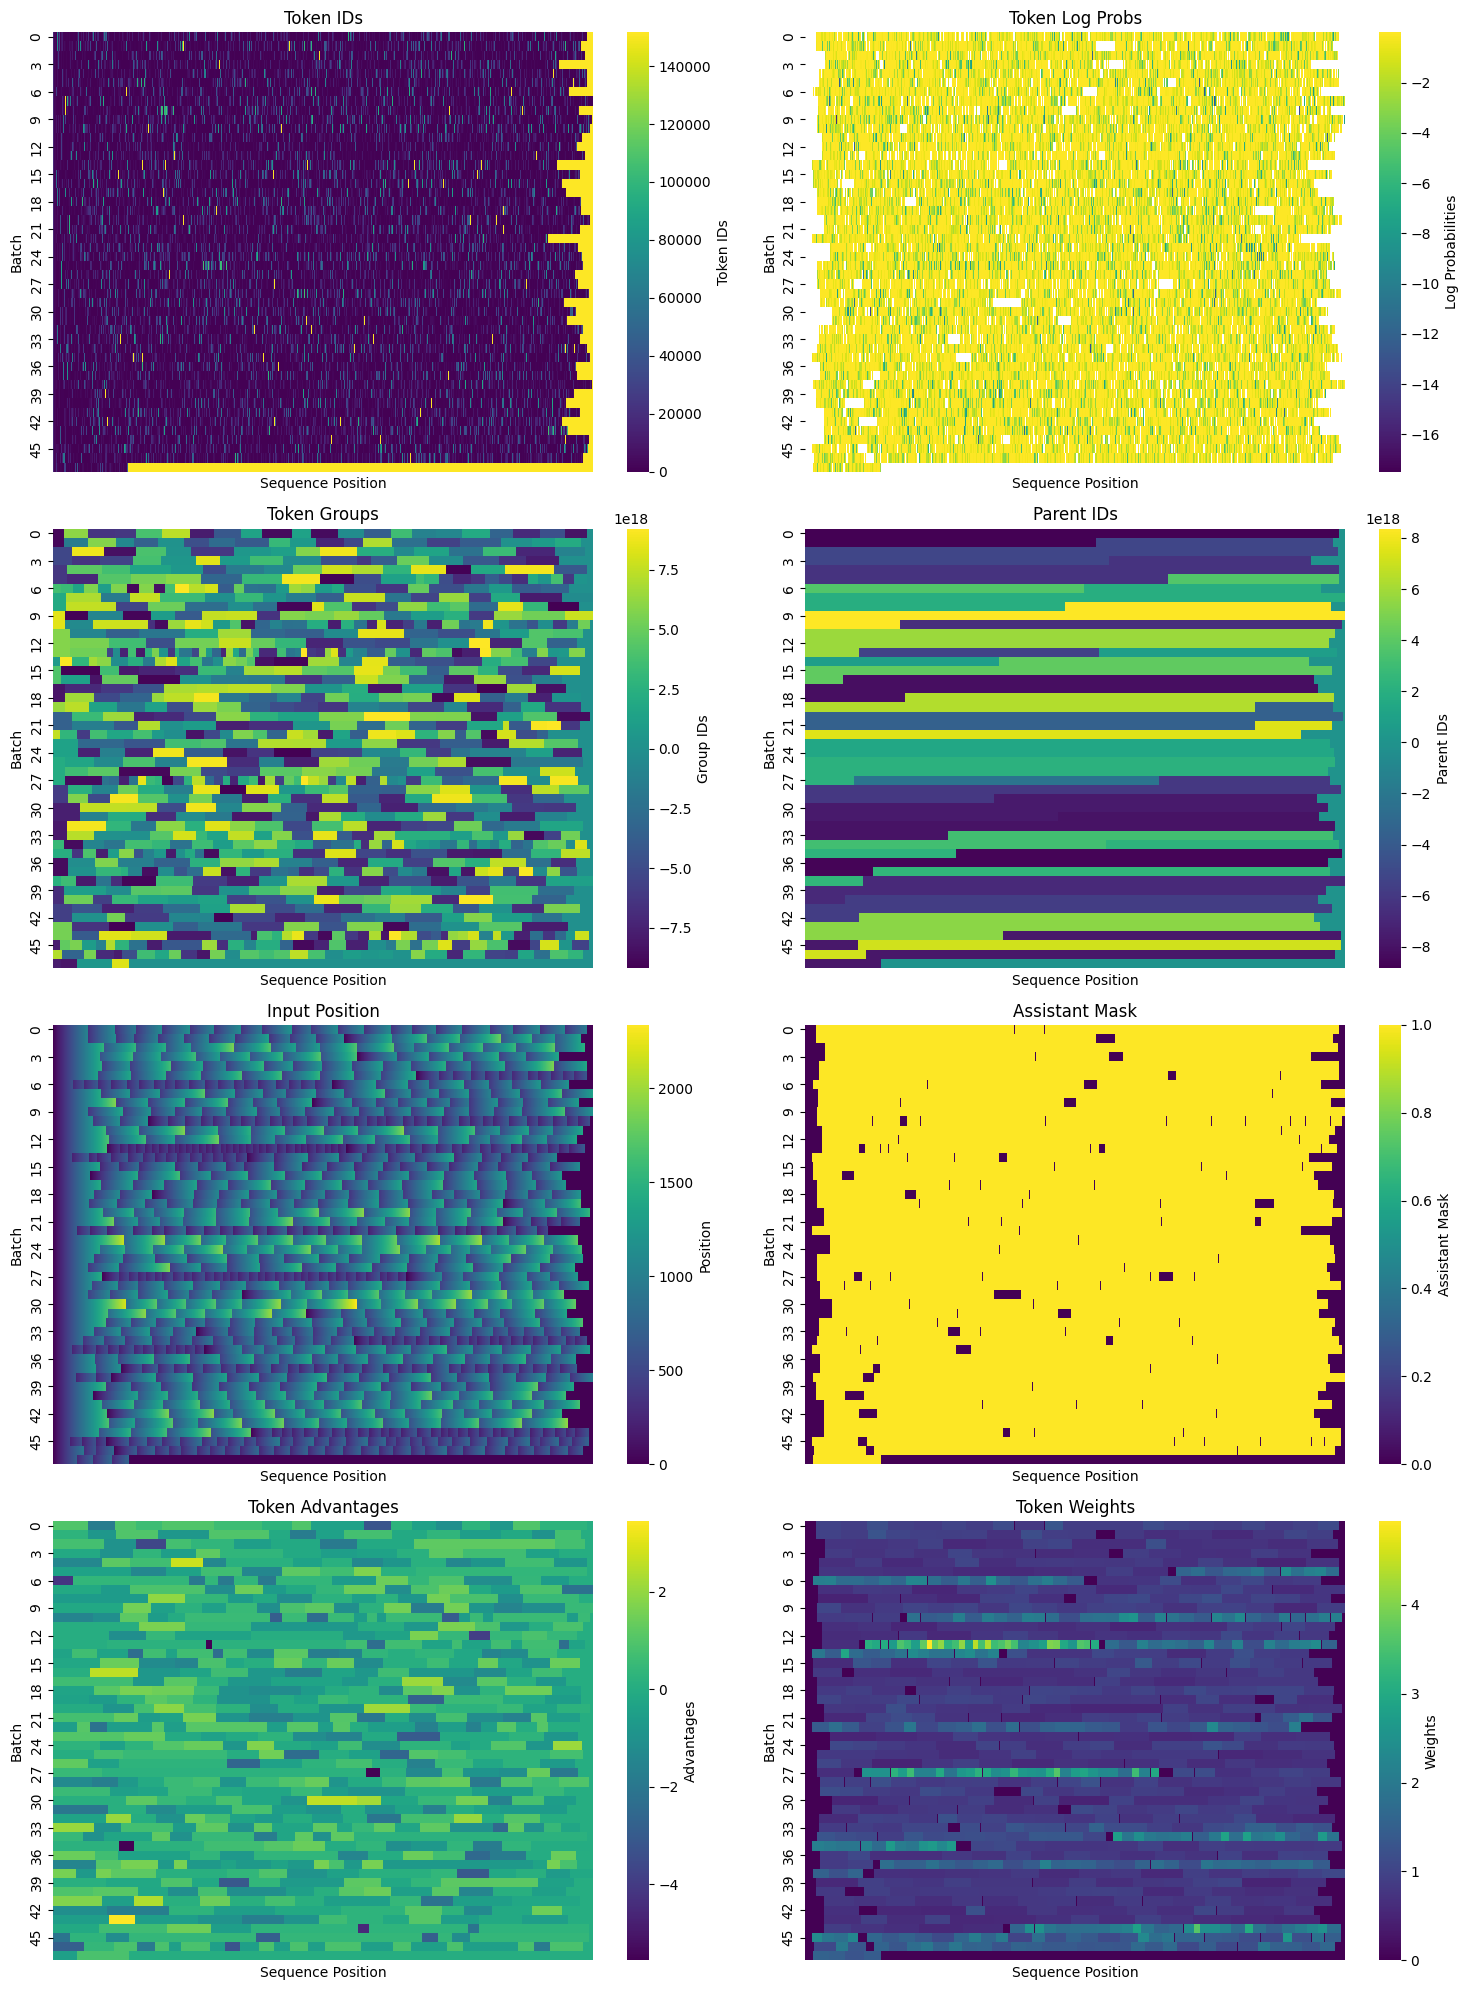

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0221 22:29:46.993000 96578 torch/distributed/run.py:793] 
W0221 22:29:46.993000 96578 torch/distributed/run.py:793] *****************************************
W0221 22:29:46.993000 96578 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0221 22:29:46.993000 96578 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0027
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007.pt


Writing logs to models/031/logs/log_1740176991.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.96 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|12|Loss: -0.0004: 100%|██████████| 12/12 [06:58<00:00, 32.67s/it, entropy=0.707, kl_div=nan, loss=-0.000398, policy=-0.000398]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

Saved iteration #28 model files to ./models/031/0028
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0028 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0028 --port=8000 --api-key=default
INFO 02-21 22:38:15 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 22:38:16 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 22:38:16 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0028', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.51s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.59s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.62s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.64s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:07,  2.60s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.62s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.64s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.13s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.43s/it]



(VllmWorkerProcess pid=99625) INFO 02-21 22:38:50 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-21 22:38:50 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=99625) INFO 02-21 22:38:53 worker.py:267] Memory profiling takes 2.18 seconds
(VllmWorkerProcess pid=99625) INFO 02-21 22:38:53 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=99625) INFO 02-21 22:38:53 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 22:38:53 worker.py:267] Memory profiling takes 2.44 seconds
INFO 02-21 22:38:53 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 22:38:53 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; Py

INFO:     Started server process [99338]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 22:39:45 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 22:39:45 metrics.py:455] Avg prompt throughput: 5.6 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 22:39:45 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:53626 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:25<00:00,  3.07s/it, completion_tokens=794, prompt_tokens=425, reward=0.635, token_logprobs=813500]
Deleted iteration directory ./models/031/0027


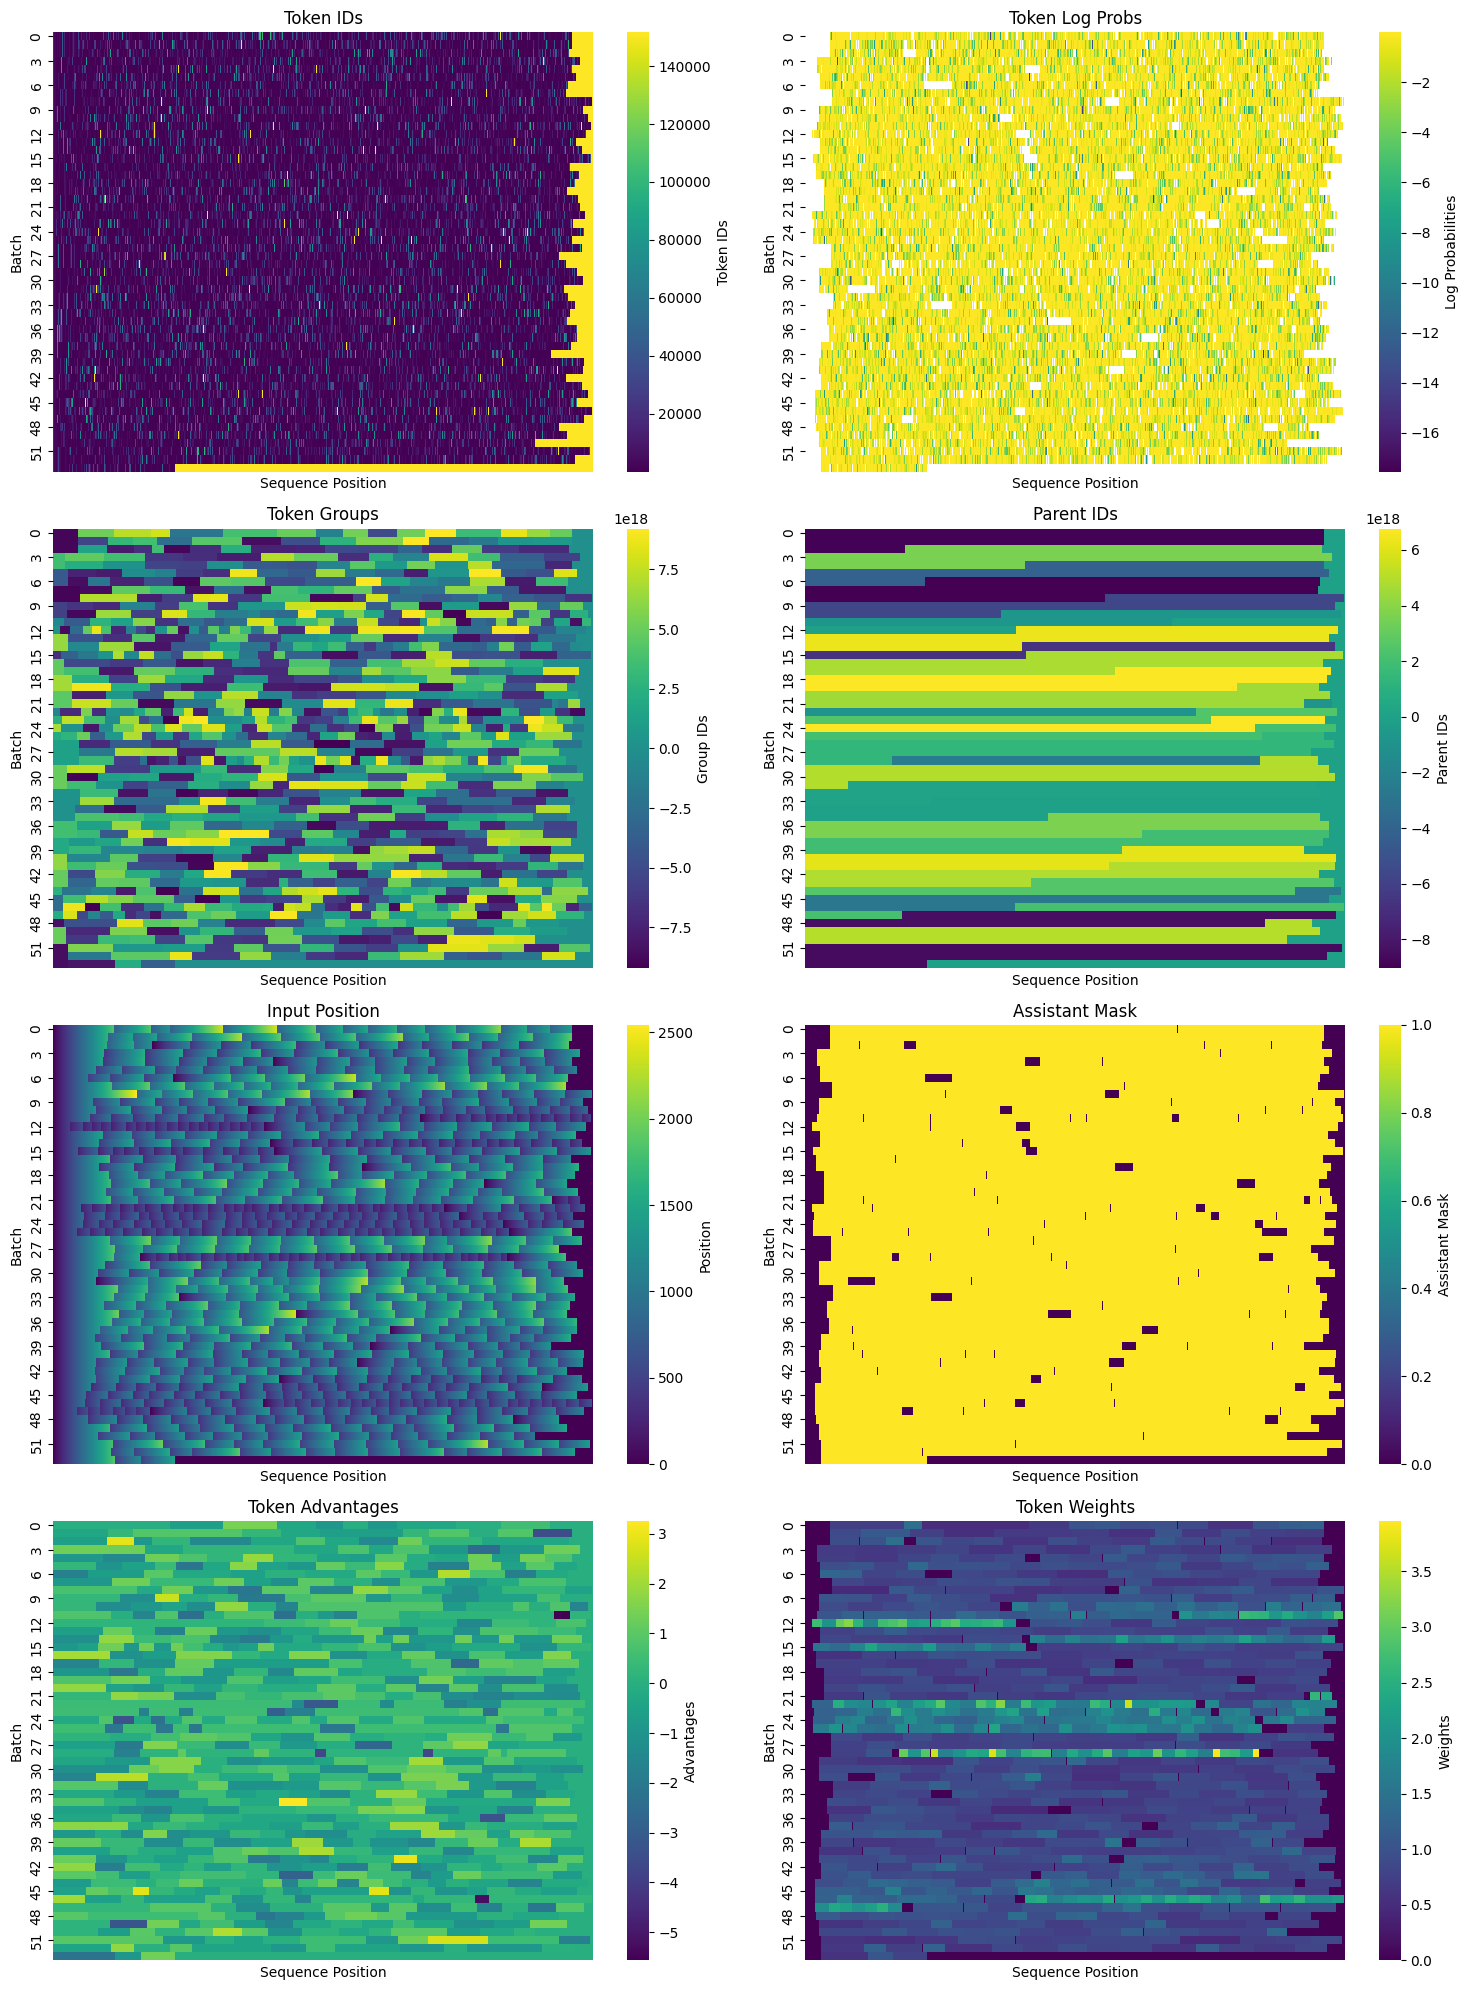

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0221 22:42:32.915000 100313 torch/distributed/run.py:793] 
W0221 22:42:32.915000 100313 torch/distributed/run.py:793] *****************************************
W0221 22:42:32.915000 100313 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0221 22:42:32.915000 100313 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0028
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007

Writing logs to models/031/logs/log_1740177757.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 25.09 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|13|Loss: 0.0001: 100%|██████████| 13/13 [07:24<00:00, 32.62s/it, entropy=0.735, kl_div=nan, loss=7.49e-5, policy=7.49e-5]    INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict..

Saved iteration #29 model files to ./models/031/0029
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0029 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0029 --port=8000 --api-key=default
INFO 02-21 22:51:28 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 22:51:29 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 22:51:29 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0029', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.56s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.64s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.66s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.69s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:07,  2.66s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.67s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.67s/it]


(VllmWorkerProcess pid=103133) INFO 02-21 22:52:03 model_runner.py:1115] Loading model weights took 13.9281 GB


Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.15s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.46s/it]



INFO 02-21 22:52:04 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=103133) INFO 02-21 22:52:06 worker.py:267] Memory profiling takes 2.33 seconds
(VllmWorkerProcess pid=103133) INFO 02-21 22:52:06 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=103133) INFO 02-21 22:52:06 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 22:52:06 worker.py:267] Memory profiling takes 2.58 seconds
INFO 02-21 22:52:06 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 22:52:06 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; PyTorch activation peak memory takes 5.70GiB; the rest of the memory reserved for KV Cache is 53.71GiB.
INFO 

INFO:     Started server process [102848]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 22:52:55 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:45200 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:19<00:00,  1.27it/s, completion_tokens=826, prompt_tokens=431, reward=0.591, token_logprobs=846046]
Deleted iteration directory ./models/031/0028


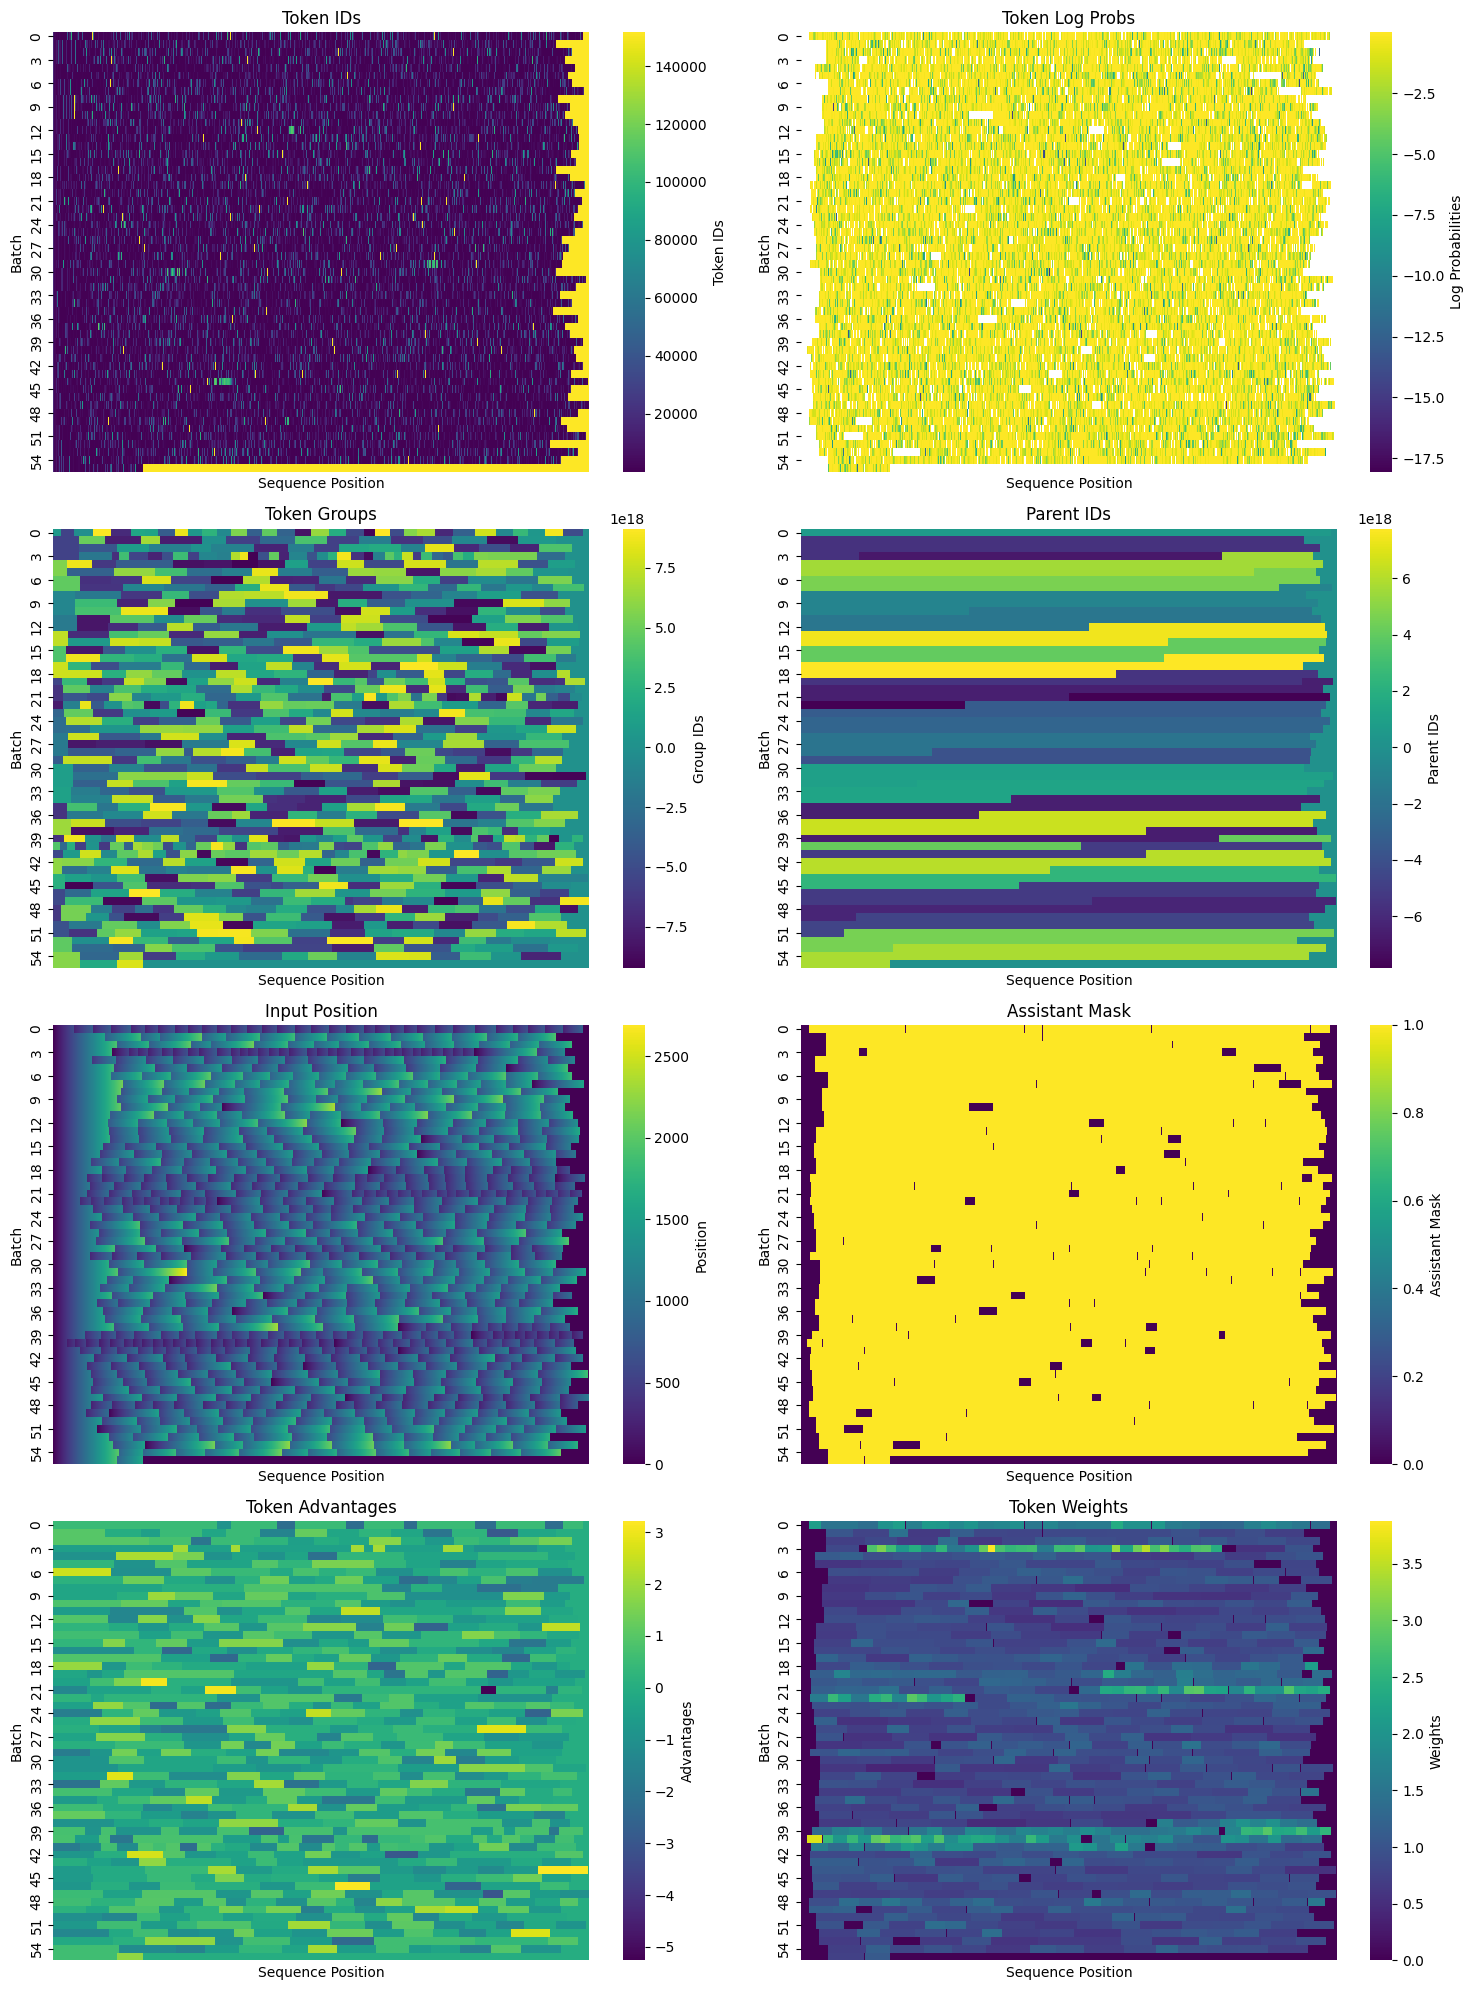

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0221 22:55:38.490000 103390 torch/distributed/run.py:793] 
W0221 22:55:38.490000 103390 torch/distributed/run.py:793] *****************************************
W0221 22:55:38.490000 103390 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0221 22:55:38.490000 103390 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0029
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007

Writing logs to models/031/logs/log_1740178543.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.01 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|14|Loss: -0.0007: 100%|██████████| 14/14 [07:57<00:00, 32.58s/it, entropy=0.82, kl_div=nan, loss=-0.000733, policy=-0.000733] INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

Saved iteration #30 model files to ./models/031/0030
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0030 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0030 --port=8000 --api-key=default
INFO 02-21 23:05:05 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 23:05:05 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 23:05:05 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0030', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.55s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.61s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.65s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.67s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:07,  2.65s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.67s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.68s/it]


(VllmWorkerProcess pid=106209) INFO 02-21 23:05:40 model_runner.py:1115] Loading model weights took 13.9281 GB


Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.15s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.45s/it]



INFO 02-21 23:05:40 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=106209) INFO 02-21 23:05:43 worker.py:267] Memory profiling takes 2.33 seconds
(VllmWorkerProcess pid=106209) INFO 02-21 23:05:43 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=106209) INFO 02-21 23:05:43 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 23:05:43 worker.py:267] Memory profiling takes 2.59 seconds
INFO 02-21 23:05:43 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 23:05:43 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; PyTorch activation peak memory takes 5.70GiB; the rest of the memory reserved for KV Cache is 53.71GiB.
INFO 

INFO:     Started server process [105923]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 23:06:30 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:43292 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:16<00:00,  1.35it/s, completion_tokens=796, prompt_tokens=431, reward=0.616, token_logprobs=815362]
Deleted iteration directory ./models/031/0029


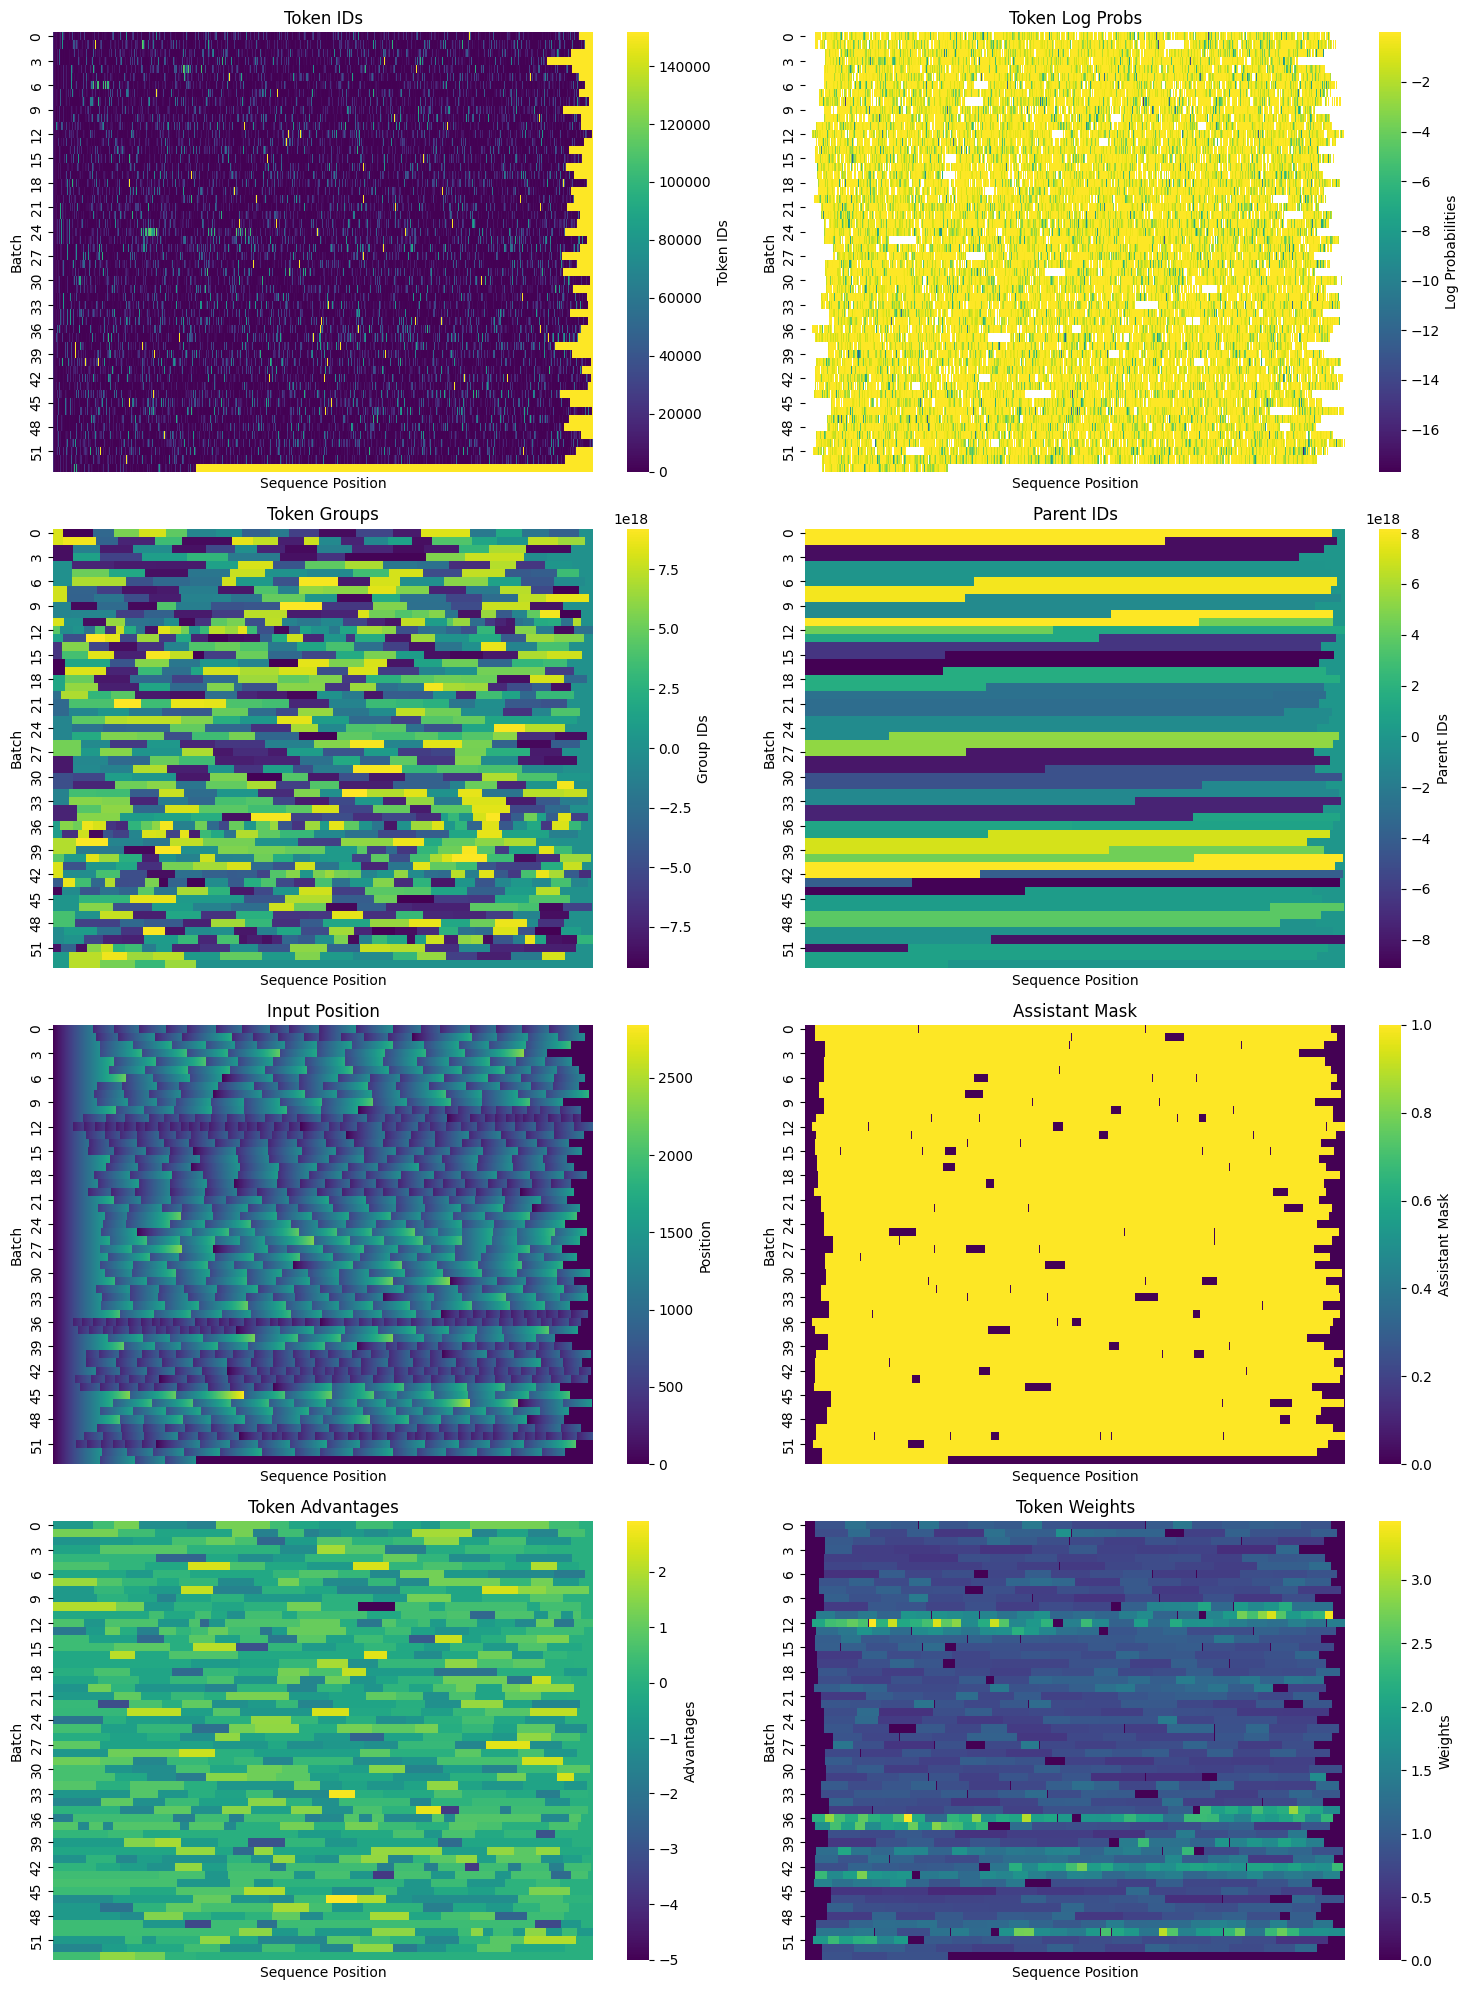

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0221 23:09:09.791000 106486 torch/distributed/run.py:793] 
W0221 23:09:09.791000 106486 torch/distributed/run.py:793] *****************************************
W0221 23:09:09.791000 106486 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0221 23:09:09.791000 106486 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0030
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007

Writing logs to models/031/logs/log_1740179354.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 25.20 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|13|Loss: 0.0000: 100%|██████████| 13/13 [07:24<00:00, 32.61s/it, entropy=0.627, kl_div=nan, loss=1.95e-5, policy=1.95e-5]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

Saved iteration #31 model files to ./models/031/0031
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0031 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0031 --port=8000 --api-key=default
INFO 02-21 23:18:05 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 23:18:05 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 23:18:05 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0031', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.49s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.56s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:12,  2.59s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.61s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:12<00:07,  2.58s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.59s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.59s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.08s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.39s/it]



INFO 02-21 23:18:40 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=109063) INFO 02-21 23:18:40 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=109063) INFO 02-21 23:18:42 worker.py:267] Memory profiling takes 2.23 seconds
(VllmWorkerProcess pid=109063) INFO 02-21 23:18:42 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=109063) INFO 02-21 23:18:42 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 23:18:42 worker.py:267] Memory profiling takes 2.26 seconds
INFO 02-21 23:18:42 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 23:18:42 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [108778]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 23:19:30 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:41578 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:16<00:00,  1.02it/s, completion_tokens=824, prompt_tokens=425, reward=0.652, token_logprobs=843495]
Deleted iteration directory ./models/031/0030


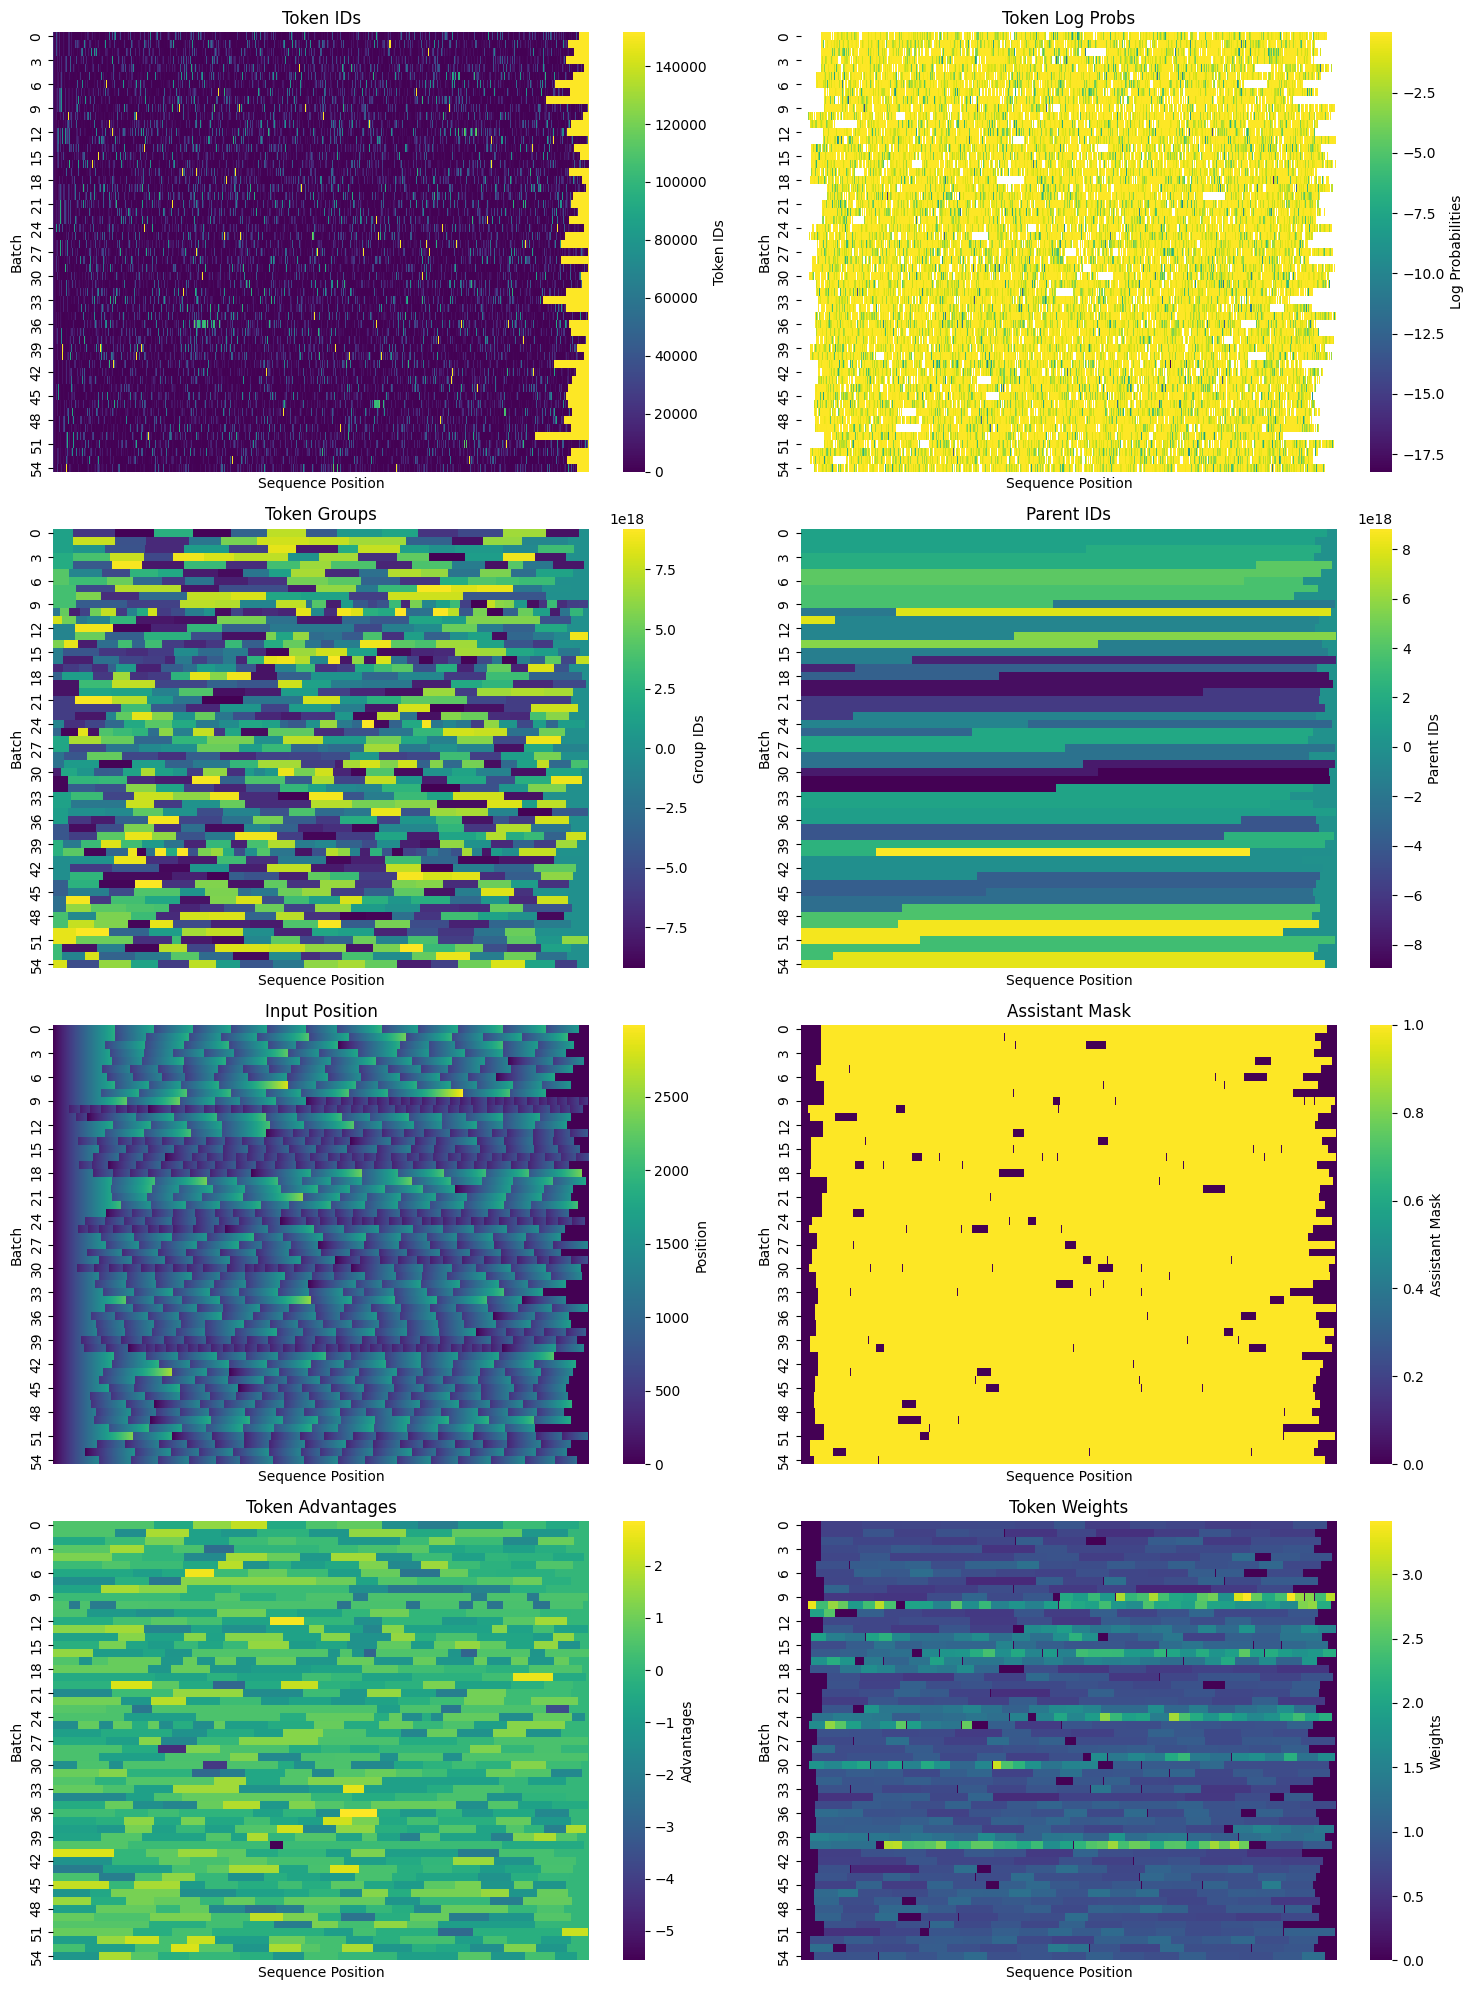

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0221 23:22:08.962000 109768 torch/distributed/run.py:793] 
W0221 23:22:08.962000 109768 torch/distributed/run.py:793] *****************************************
W0221 23:22:08.962000 109768 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0221 23:22:08.962000 109768 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0031
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007

Writing logs to models/031/logs/log_1740180133.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 25.26 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|14|Loss: -0.0023: 100%|██████████| 14/14 [07:57<00:00, 32.68s/it, entropy=0.66, kl_div=nan, loss=-0.0023, policy=-0.0023] INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
I

Saved iteration #32 model files to ./models/031/0032
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0032 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0032 --port=8000 --api-key=default
INFO 02-21 23:31:37 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 23:31:38 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 23:31:38 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0032', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.54s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.61s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.66s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.67s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:07,  2.65s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.67s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.67s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.14s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.45s/it]



(VllmWorkerProcess pid=112531) INFO 02-21 23:32:13 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-21 23:32:13 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=112531) INFO 02-21 23:32:15 worker.py:267] Memory profiling takes 2.28 seconds
(VllmWorkerProcess pid=112531) INFO 02-21 23:32:15 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=112531) INFO 02-21 23:32:15 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 23:32:16 worker.py:267] Memory profiling takes 2.37 seconds
INFO 02-21 23:32:16 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 23:32:16 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [112246]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 23:33:09 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 23:33:09 metrics.py:455] Avg prompt throughput: 4.3 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 23:33:09 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:48314 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:31<00:00,  1.24s/it, completion_tokens=888, prompt_tokens=442, reward=0.583, token_logprobs=909451]
Deleted iteration directory ./models/031/0031


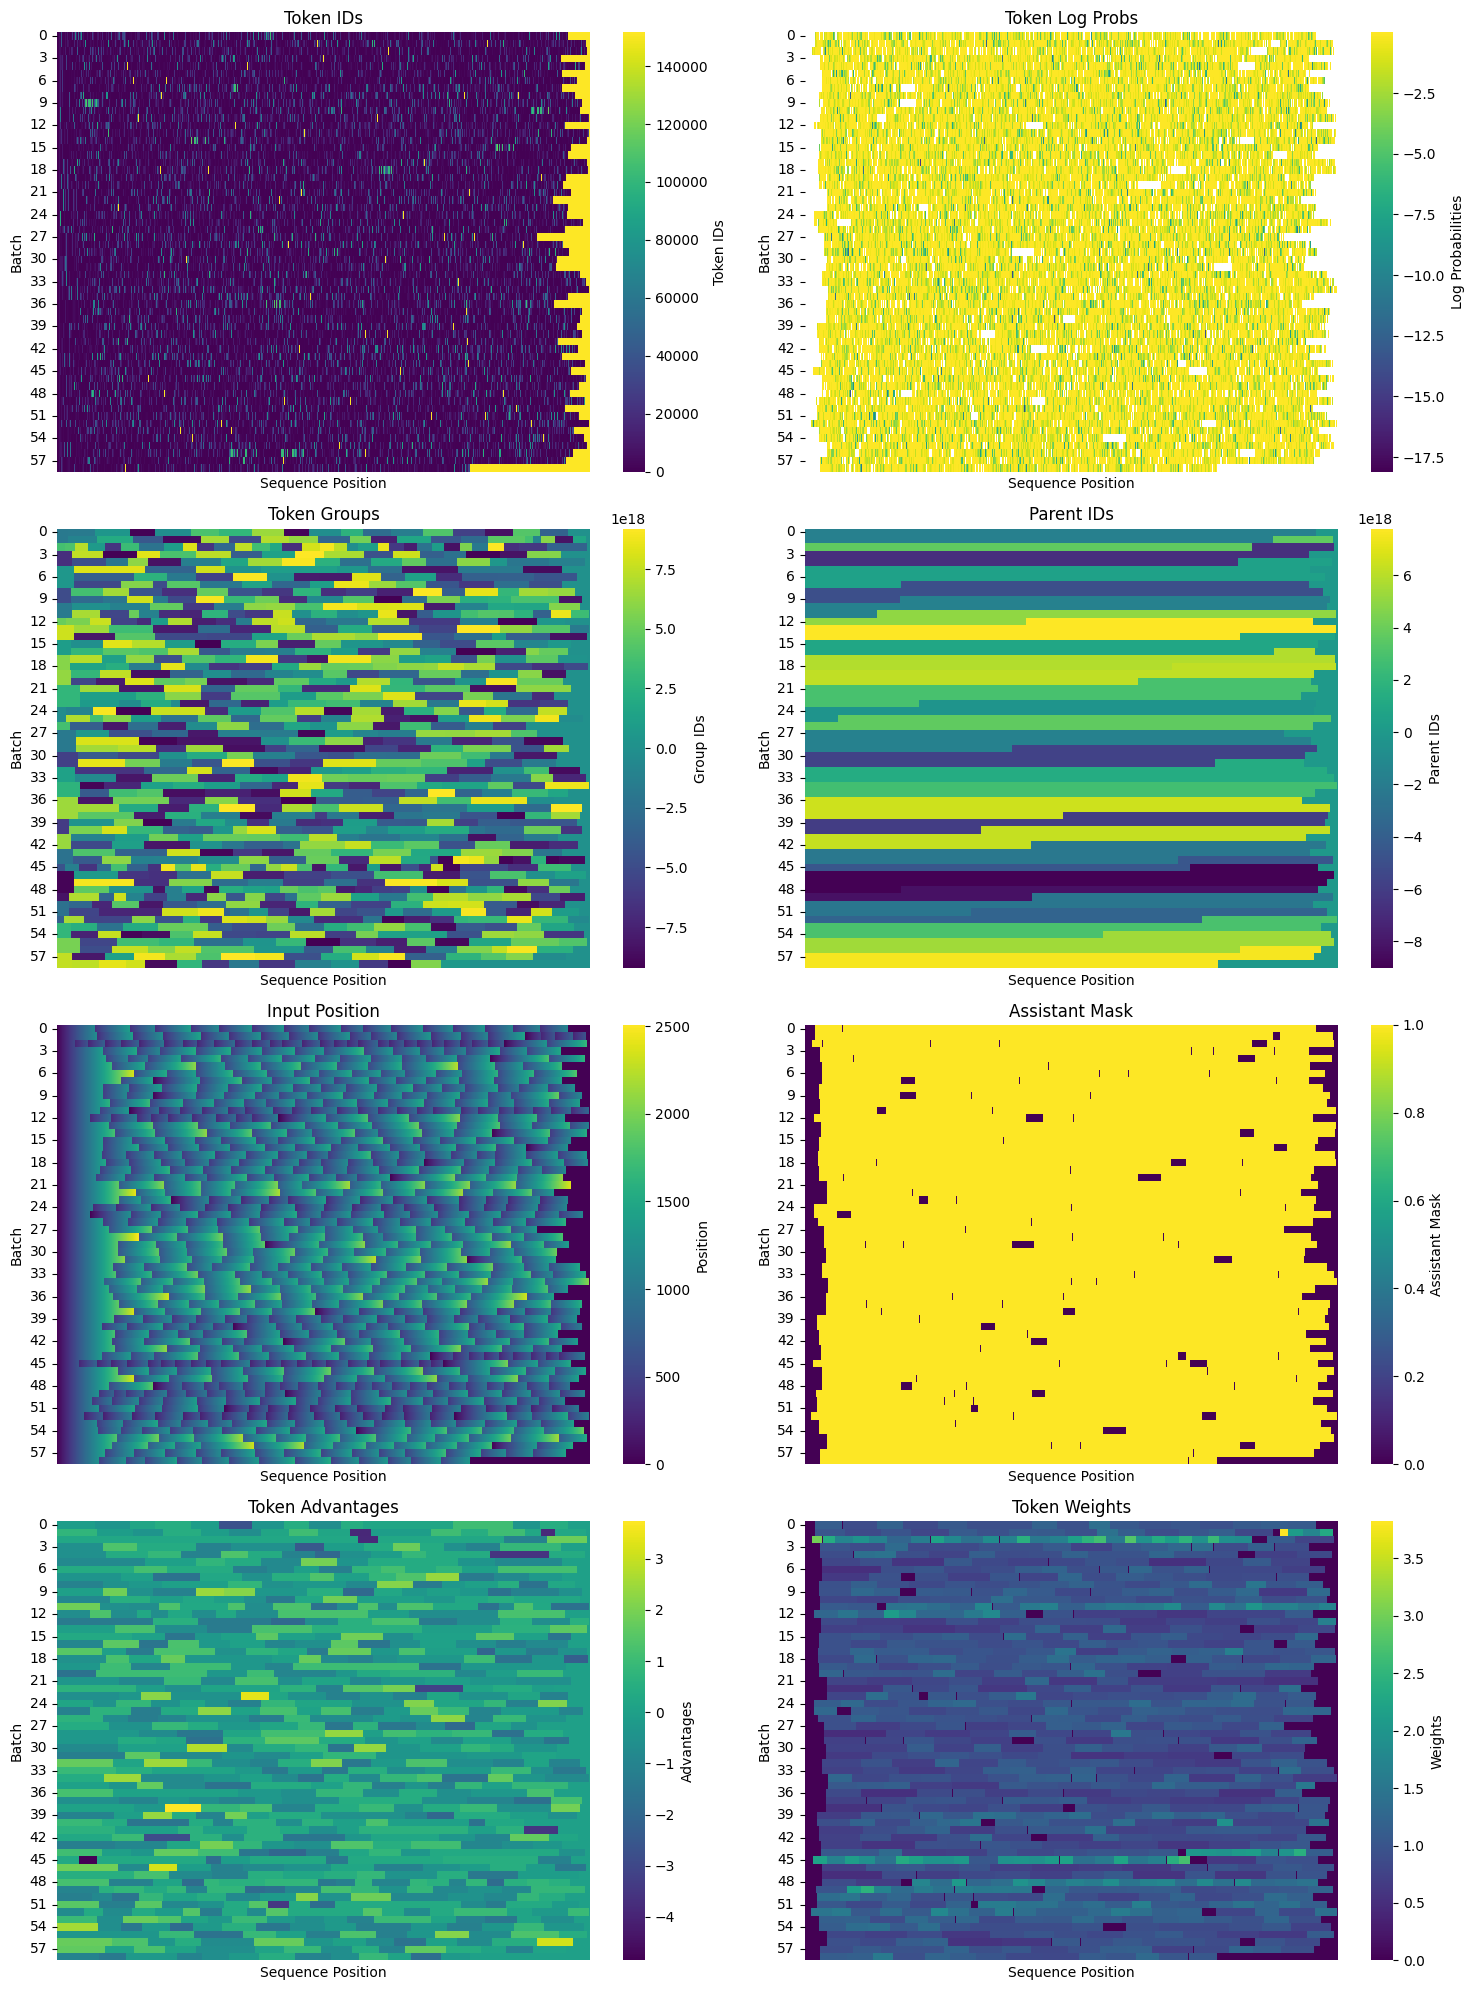

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0221 23:36:04.203000 112809 torch/distributed/run.py:793] 
W0221 23:36:04.203000 112809 torch/distributed/run.py:793] *****************************************
W0221 23:36:04.203000 112809 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0221 23:36:04.203000 112809 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0032
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - 

Writing logs to models/031/logs/log_1740180969.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.92 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|15|Loss: -0.0008: 100%|██████████| 15/15 [08:30<00:00, 32.57s/it, entropy=0.647, kl_div=nan, loss=-0.000755, policy=-0.000755]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

Saved iteration #33 model files to ./models/031/0033
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0033 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0033 --port=8000 --api-key=default
INFO 02-21 23:46:04 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 23:46:05 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 23:46:05 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0033', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.52s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.63s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.65s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.64s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:07,  2.60s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.66s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.66s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.14s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.44s/it]



(VllmWorkerProcess pid=115552) INFO 02-21 23:46:39 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-21 23:46:39 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=115552) INFO 02-21 23:46:42 worker.py:267] Memory profiling takes 2.32 seconds
(VllmWorkerProcess pid=115552) INFO 02-21 23:46:42 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=115552) INFO 02-21 23:46:42 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-21 23:46:42 worker.py:267] Memory profiling takes 2.41 seconds
INFO 02-21 23:46:42 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-21 23:46:42 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [115267]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 23:47:34 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 23:47:34 metrics.py:455] Avg prompt throughput: 5.2 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 23:47:34 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:52068 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:36<00:00,  5.96it/s, completion_tokens=893, prompt_tokens=456, reward=0.57, token_logprobs=914155]
Deleted iteration directory ./models/031/0032


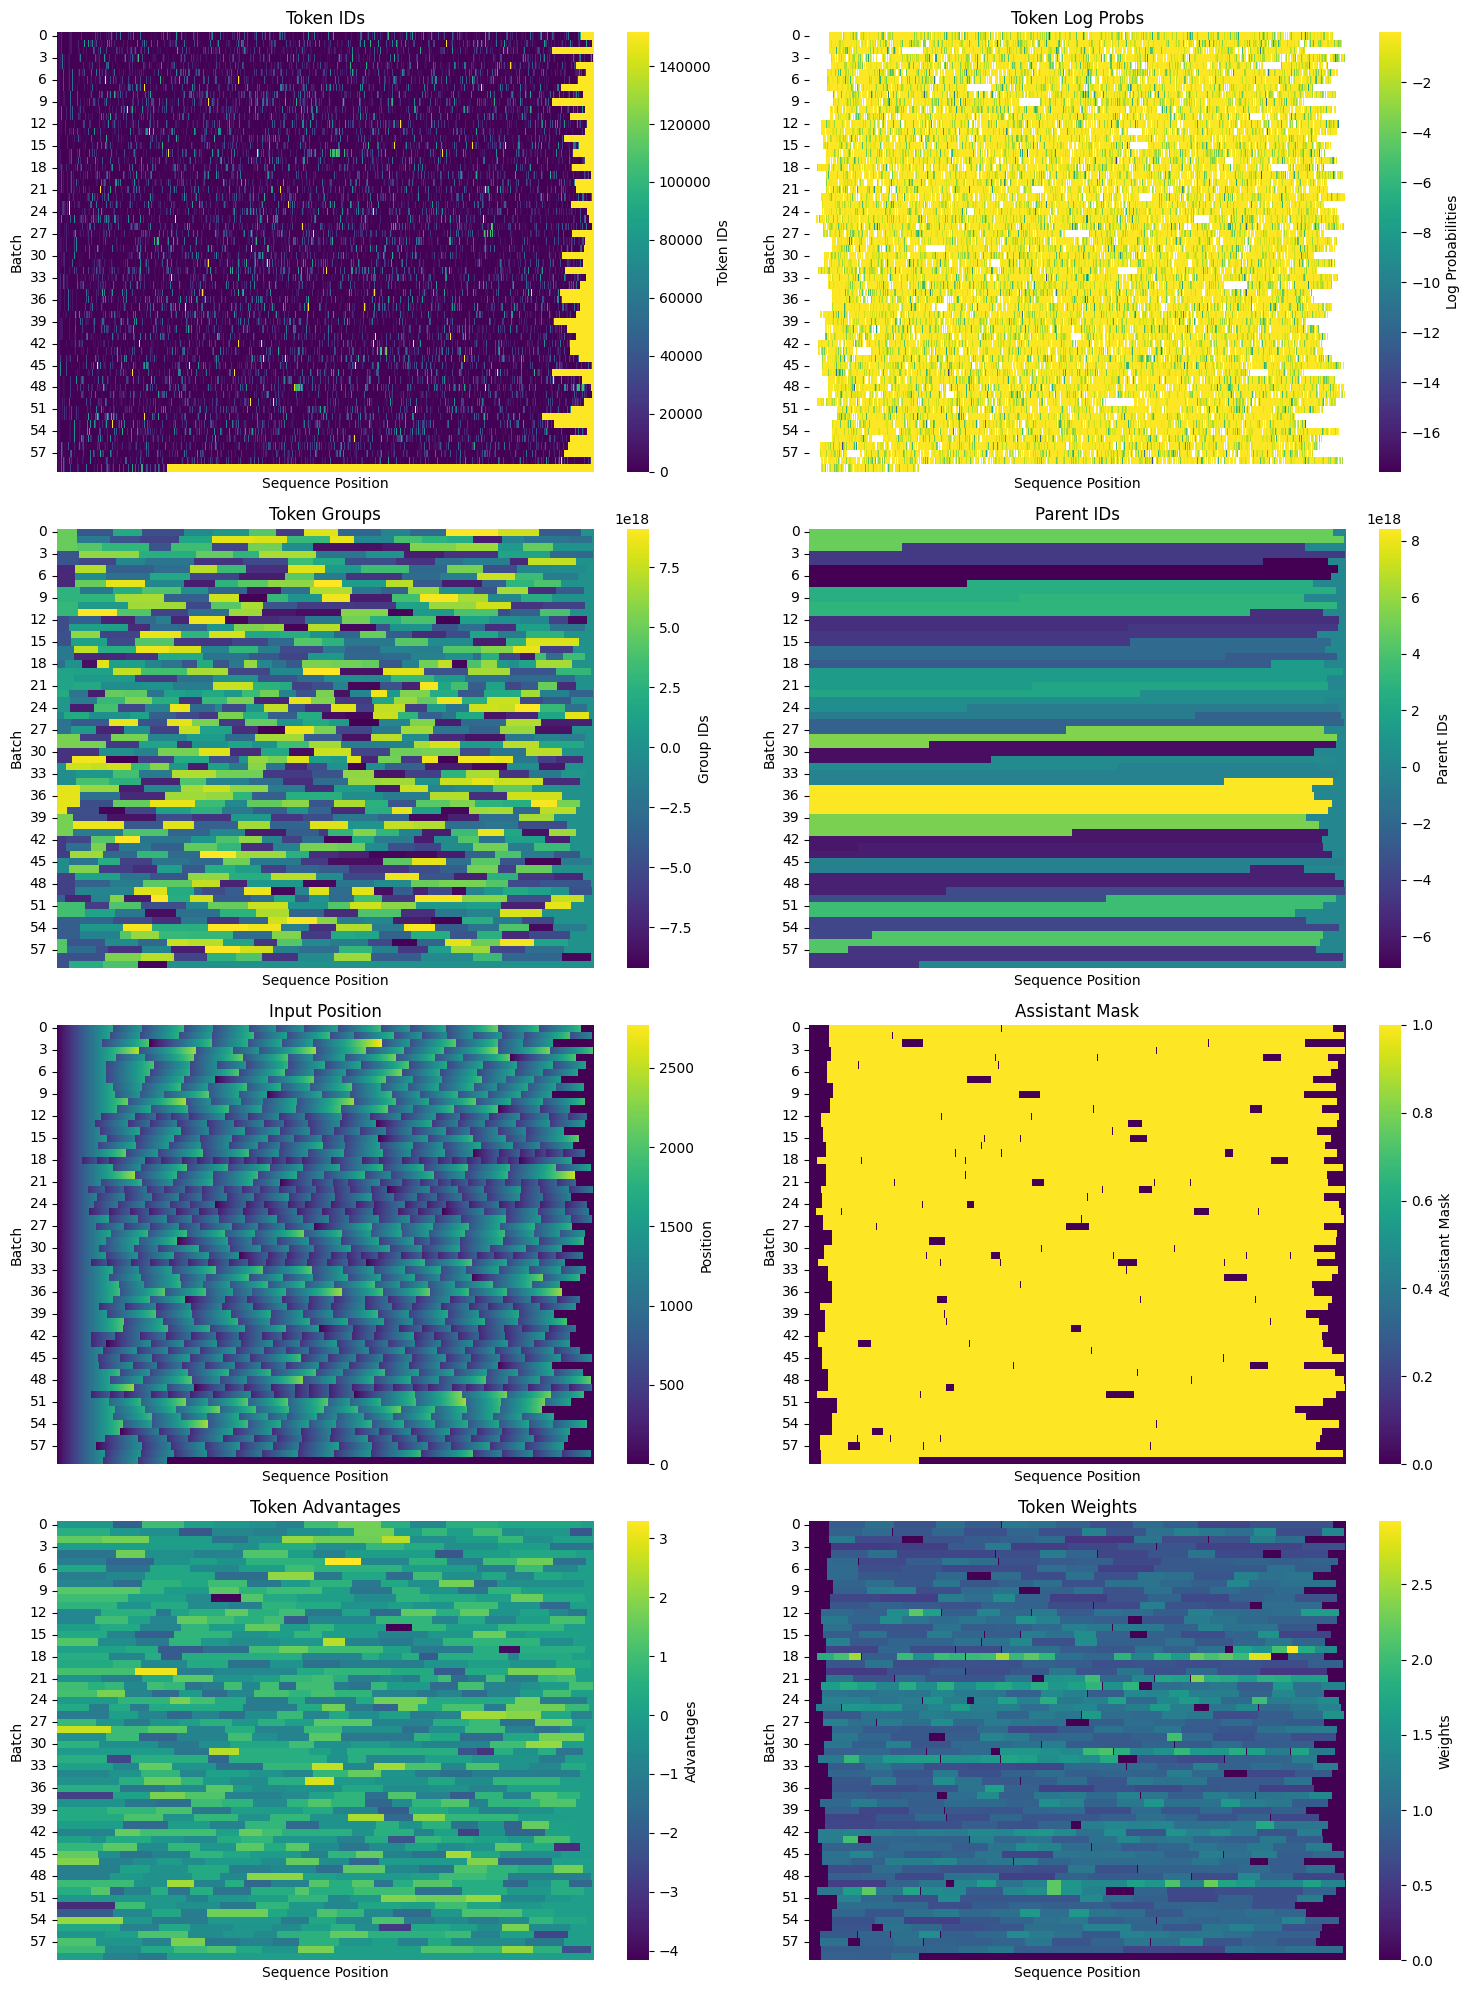

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0221 23:50:34.407000 115830 torch/distributed/run.py:793] 
W0221 23:50:34.407000 115830 torch/distributed/run.py:793] *****************************************
W0221 23:50:34.407000 115830 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0221 23:50:34.407000 115830 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0033
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007

Writing logs to models/031/logs/log_1740181839.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 23.92 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|15|Loss: -0.0001: 100%|██████████| 15/15 [08:29<00:00, 32.56s/it, entropy=0.713, kl_div=nan, loss=-0.00011, policy=-0.00011]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

Saved iteration #34 model files to ./models/031/0034
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0034 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0034 --port=8000 --api-key=default
INFO 02-22 00:00:33 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 00:00:34 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 00:00:34 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0034', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.52s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.62s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.64s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.65s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:07,  2.63s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.63s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.64s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.11s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.43s/it]



(VllmWorkerProcess pid=119138) INFO 02-22 00:01:09 model_runner.py:1115] Loading model weights took 13.9281 GB
INFO 02-22 00:01:09 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=119138) INFO 02-22 00:01:11 worker.py:267] Memory profiling takes 2.25 seconds
(VllmWorkerProcess pid=119138) INFO 02-22 00:01:11 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=119138) INFO 02-22 00:01:11 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-22 00:01:11 worker.py:267] Memory profiling takes 2.33 seconds
INFO 02-22 00:01:11 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-22 00:01:11 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [118419]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 00:02:03 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-22 00:02:04 metrics.py:455] Avg prompt throughput: 5.2 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-22 00:02:04 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:34506 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:28<00:00,  1.68s/it, completion_tokens=841, prompt_tokens=417, reward=0.644, token_logprobs=861397]
Deleted iteration directory ./models/031/0033


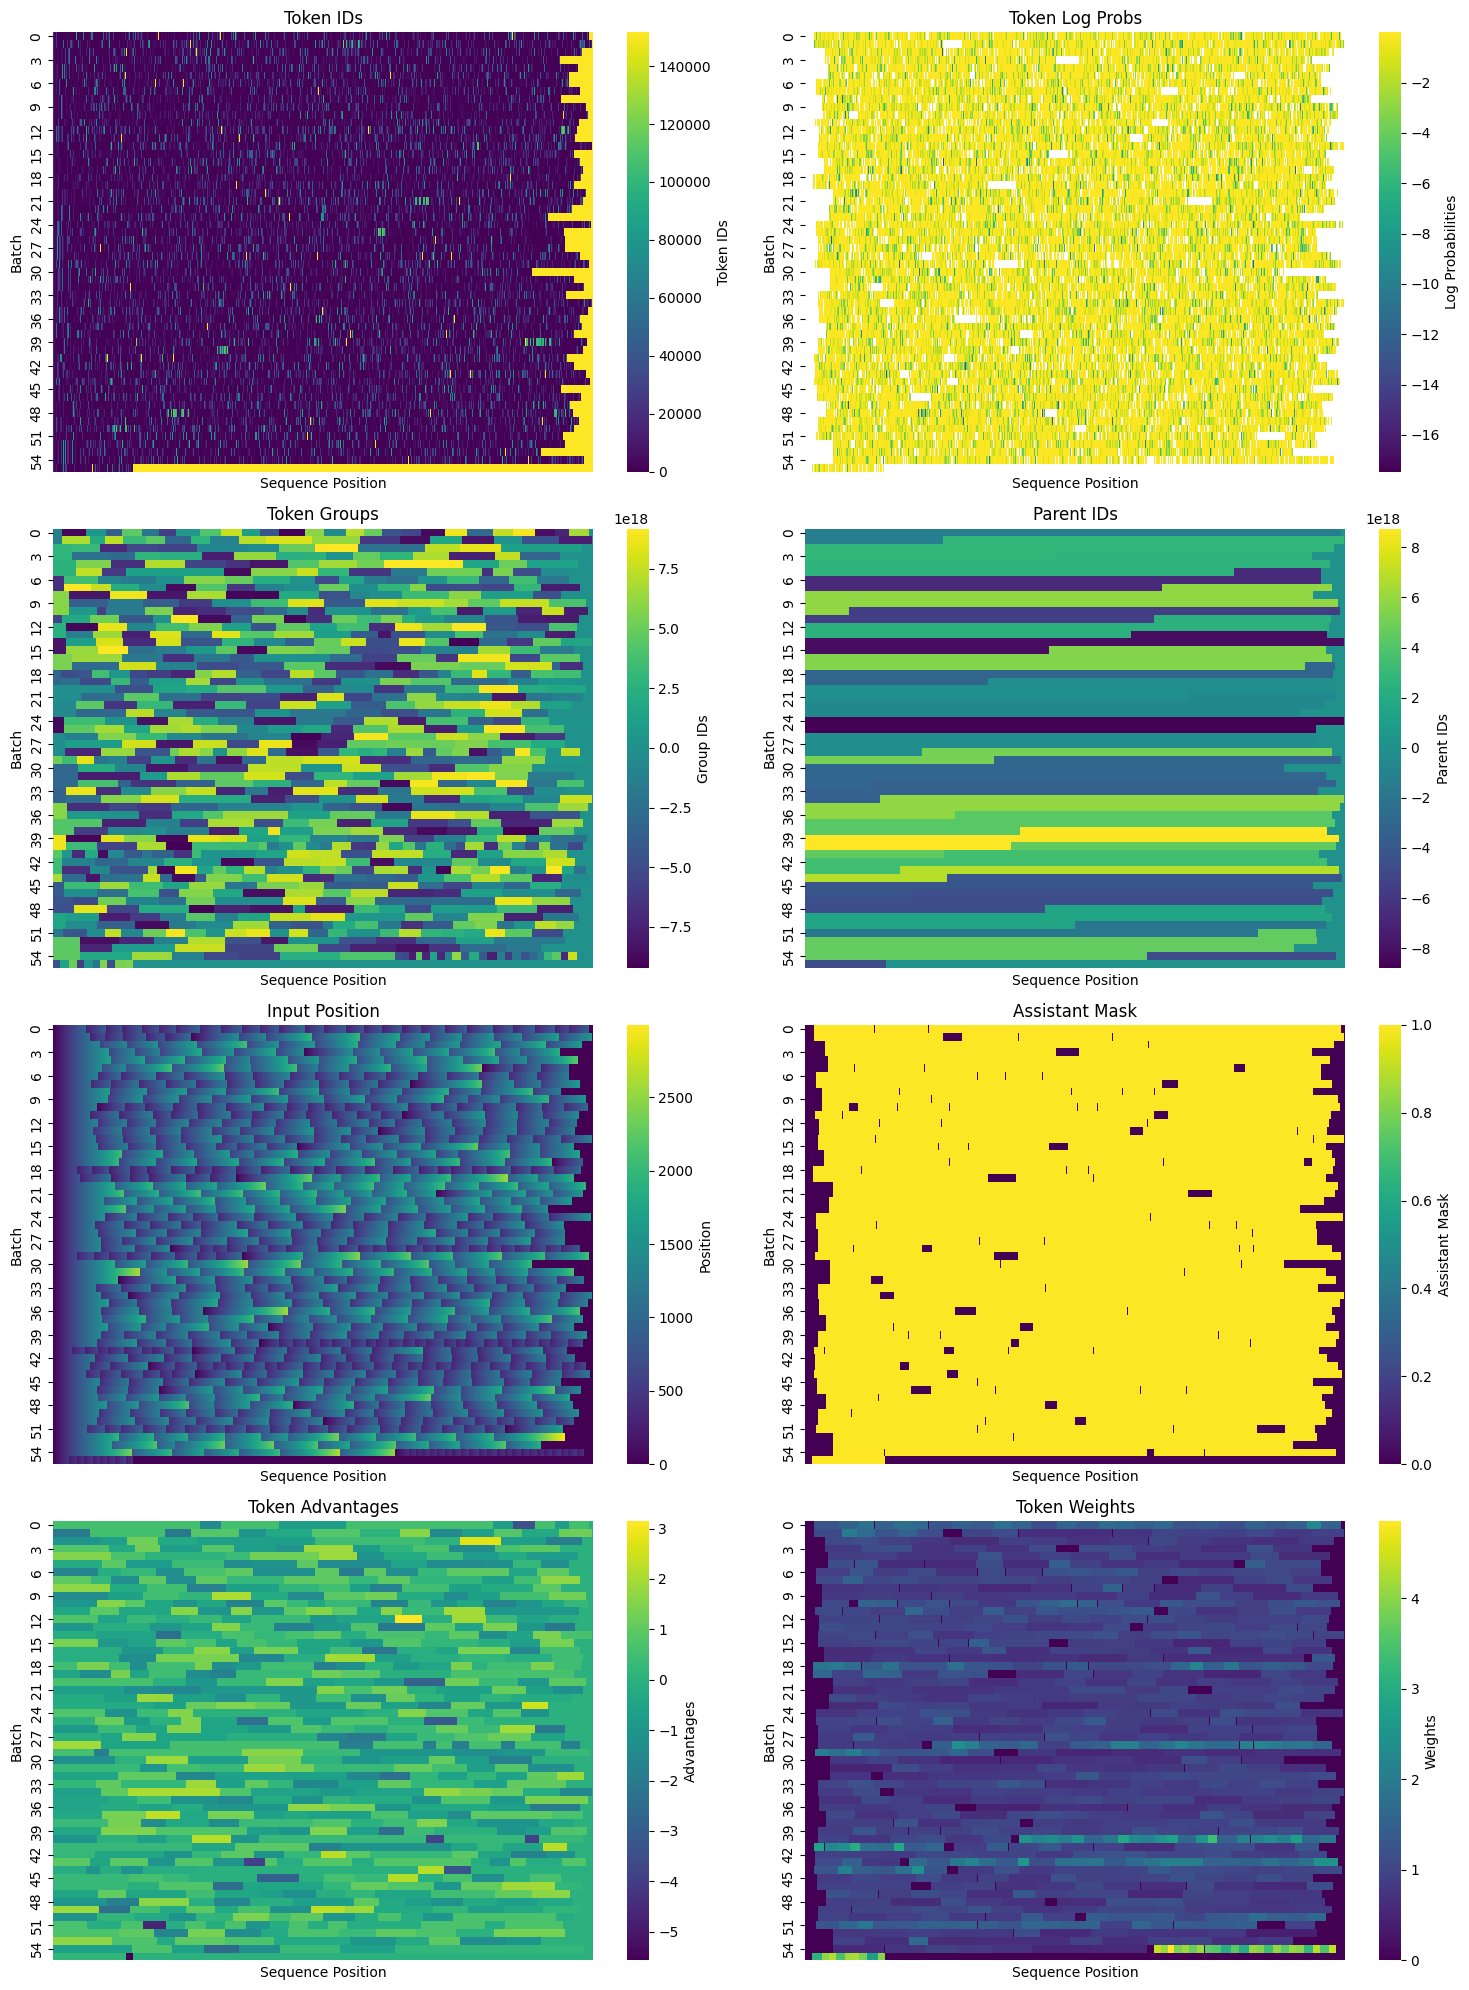

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0222 00:04:55.787000 119398 torch/distributed/run.py:793] 
W0222 00:04:55.787000 119398 torch/distributed/run.py:793] *****************************************
W0222 00:04:55.787000 119398 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0222 00:04:55.787000 119398 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0034
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007

Writing logs to models/031/logs/log_1740182700.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 25.22 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|14|Loss: -0.0000: 100%|██████████| 14/14 [07:57<00:00, 32.57s/it, entropy=0.732, kl_div=nan, loss=-1.89e-5, policy=-1.89e-5]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

Saved iteration #35 model files to ./models/031/0035
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0035 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0035 --port=8000 --api-key=default
INFO 02-22 00:14:23 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 00:14:24 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 00:14:24 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0035', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.56s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.63s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.66s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.66s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:07,  2.65s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.67s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.67s/it]


(VllmWorkerProcess pid=122119) INFO 02-22 00:14:58 model_runner.py:1115] Loading model weights took 13.9281 GB


Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.14s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.45s/it]



INFO 02-22 00:14:59 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=122119) INFO 02-22 00:15:01 worker.py:267] Memory profiling takes 2.19 seconds
(VllmWorkerProcess pid=122119) INFO 02-22 00:15:01 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=122119) INFO 02-22 00:15:01 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-22 00:15:01 worker.py:267] Memory profiling takes 2.46 seconds
INFO 02-22 00:15:01 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-22 00:15:01 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; PyTorch activation peak memory takes 5.70GiB; the rest of the memory reserved for KV Cache is 53.71GiB.
INFO 

INFO:     Started server process [121833]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 00:15:50 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:36226 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:32<00:00,  1.56s/it, completion_tokens=865, prompt_tokens=421, reward=0.632, token_logprobs=885380]
Deleted iteration directory ./models/031/0034


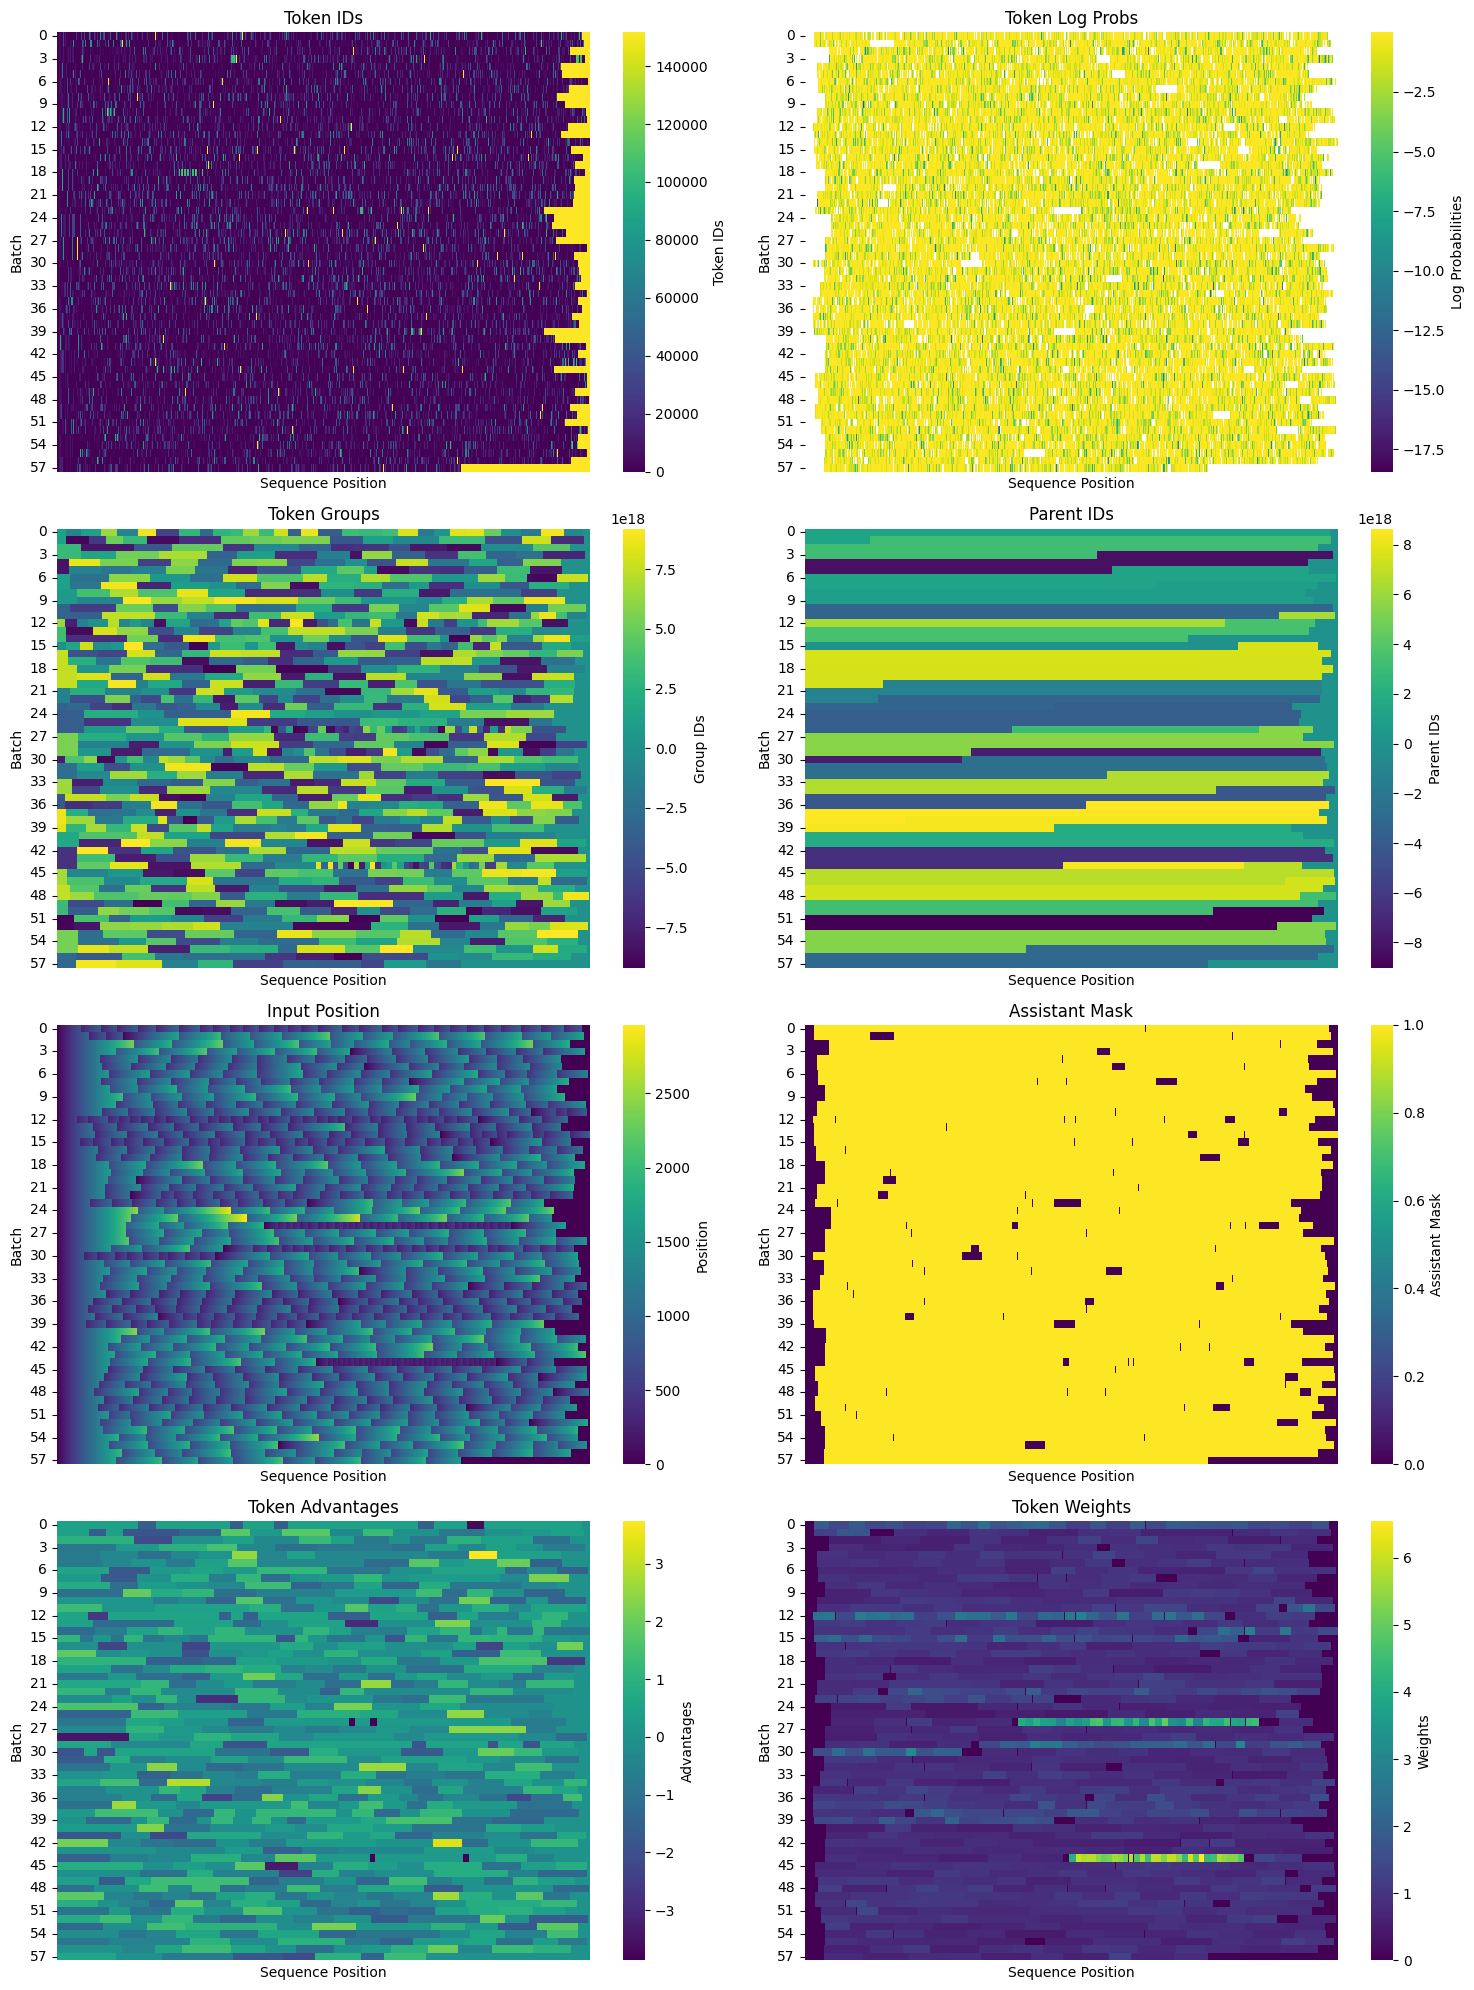

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0222 00:18:46.810000 122439 torch/distributed/run.py:793] 
W0222 00:18:46.810000 122439 torch/distributed/run.py:793] *****************************************
W0222 00:18:46.810000 122439 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0222 00:18:46.810000 122439 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0035
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - 

Writing logs to models/031/logs/log_1740183531.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.99 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|14|Loss: 0.0001: 100%|██████████| 14/14 [07:57<00:00, 32.57s/it, entropy=0.577, kl_div=nan, loss=6.89e-5, policy=6.89e-5]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

Saved iteration #36 model files to ./models/031/0036
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0036 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0036 --port=8000 --api-key=default
INFO 02-22 00:28:14 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 00:28:15 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 00:28:15 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0036', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.56s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.65s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.68s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.70s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:08,  2.68s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:16<00:05,  2.67s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.67s/it]


(VllmWorkerProcess pid=124989) INFO 02-22 00:28:49 model_runner.py:1115] Loading model weights took 13.9281 GB


Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.14s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.46s/it]



INFO 02-22 00:28:50 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=124989) INFO 02-22 00:28:52 worker.py:267] Memory profiling takes 2.33 seconds
(VllmWorkerProcess pid=124989) INFO 02-22 00:28:52 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=124989) INFO 02-22 00:28:52 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-22 00:28:52 worker.py:267] Memory profiling takes 2.40 seconds
INFO 02-22 00:28:52 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-22 00:28:52 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; PyTorch activation peak memory takes 5.70GiB; the rest of the memory reserved for KV Cache is 53.71GiB.
INFO 

INFO:     Started server process [124704]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 00:29:42 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:38666 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:26<00:00,  1.23it/s, completion_tokens=873, prompt_tokens=392, reward=0.661, token_logprobs=893537]
Deleted iteration directory ./models/031/0035


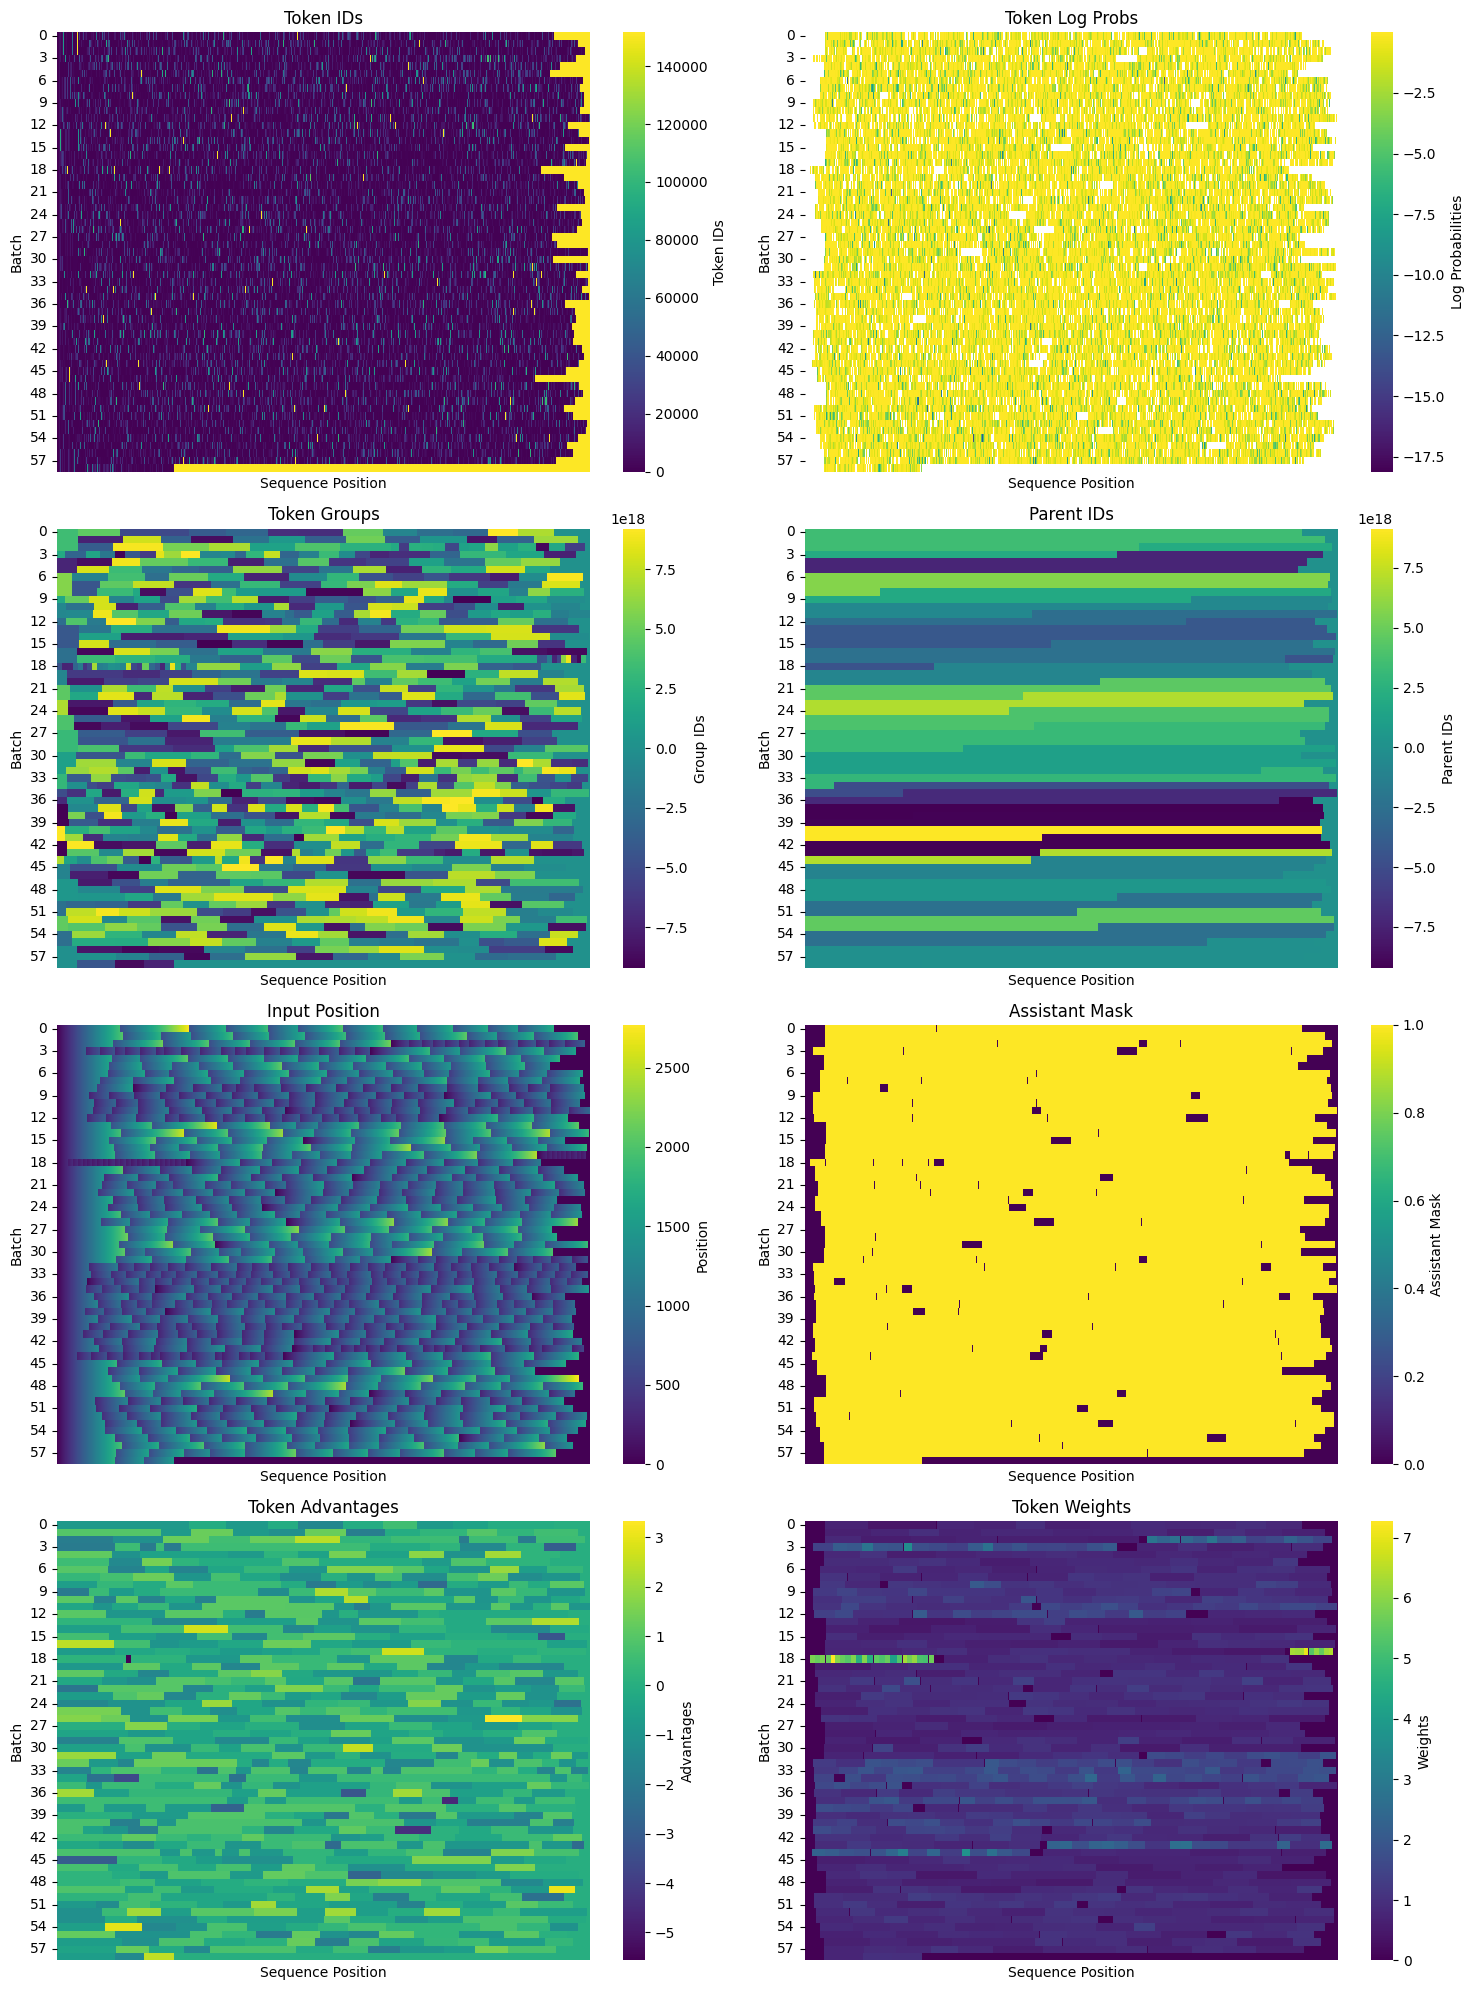

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0222 00:32:33.166000 125695 torch/distributed/run.py:793] 
W0222 00:32:33.166000 125695 torch/distributed/run.py:793] *****************************************
W0222 00:32:33.166000 125695 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0222 00:32:33.166000 125695 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0036
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007

Writing logs to models/031/logs/log_1740184358.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 25.32 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|15|Loss: -0.0005: 100%|██████████| 15/15 [08:29<00:00, 32.56s/it, entropy=0.656, kl_div=nan, loss=-0.000469, policy=-0.000469]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

Saved iteration #37 model files to ./models/031/0037
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0037 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0037 --port=8000 --api-key=default
INFO 02-22 00:42:33 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 00:42:34 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 00:42:34 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0037', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.53s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.60s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.63s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.63s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:07,  2.62s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.63s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.64s/it]


(VllmWorkerProcess pid=128354) INFO 02-22 00:43:08 model_runner.py:1115] Loading model weights took 13.9281 GB


Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.13s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.43s/it]



INFO 02-22 00:43:08 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=128354) INFO 02-22 00:43:11 worker.py:267] Memory profiling takes 2.22 seconds
(VllmWorkerProcess pid=128354) INFO 02-22 00:43:11 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=128354) INFO 02-22 00:43:11 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-22 00:43:11 worker.py:267] Memory profiling takes 2.51 seconds
INFO 02-22 00:43:11 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-22 00:43:11 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; PyTorch activation peak memory takes 5.70GiB; the rest of the memory reserved for KV Cache is 53.71GiB.
INFO 

INFO:     Started server process [128069]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 00:43:59 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:52964 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:44<00:00,  5.28s/it, completion_tokens=887, prompt_tokens=430, reward=0.623, token_logprobs=907903]
Deleted iteration directory ./models/031/0022


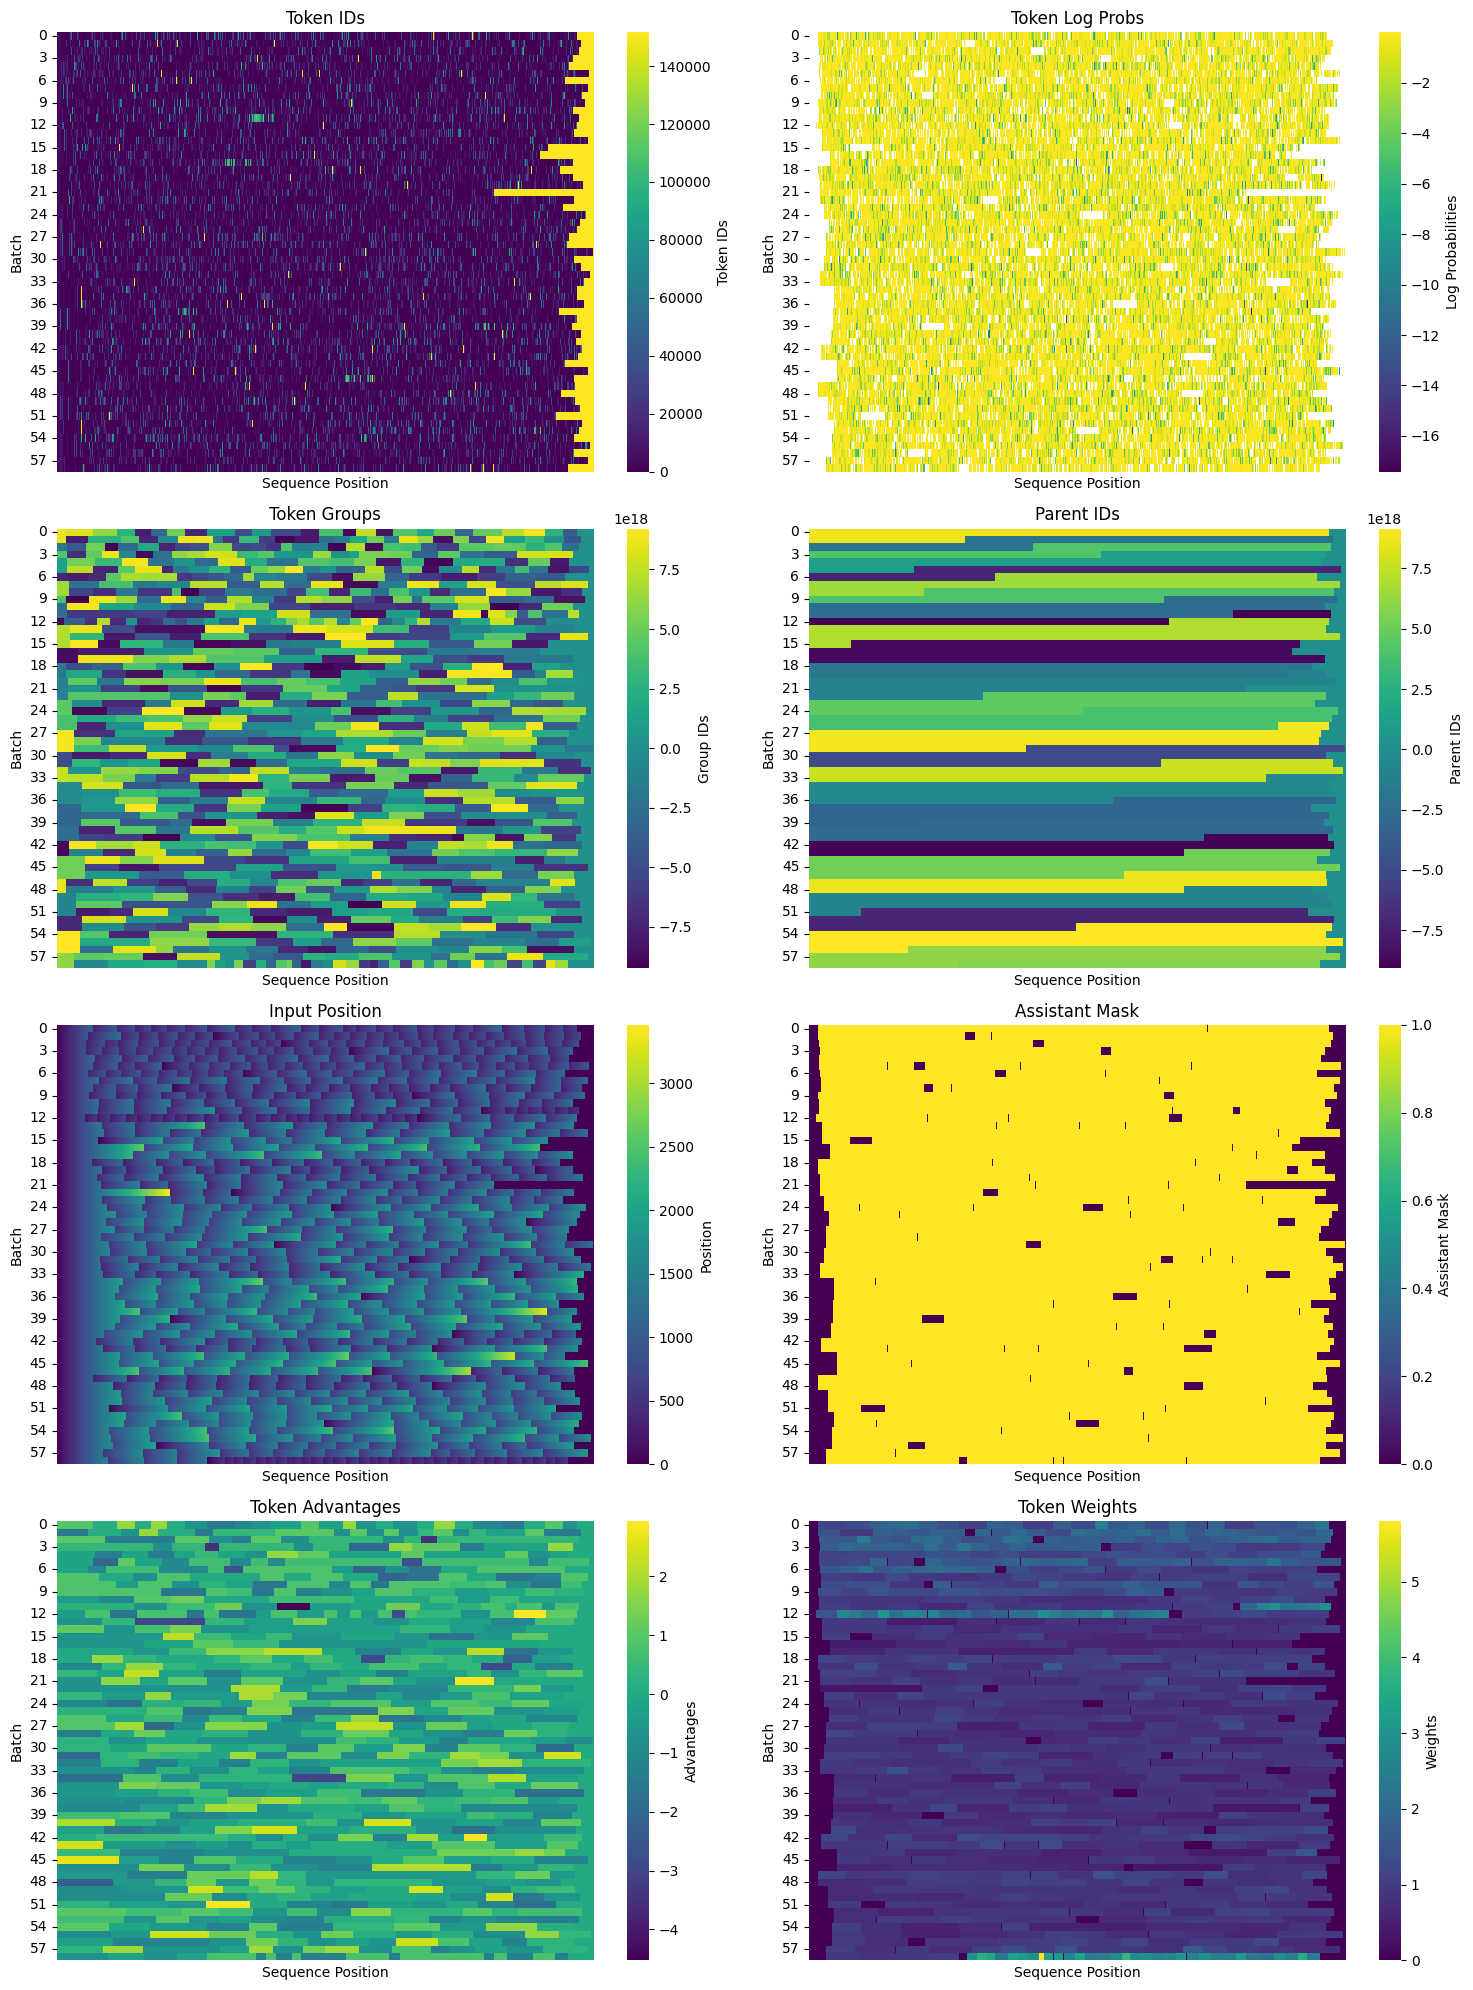

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0222 00:47:07.450000 128648 torch/distributed/run.py:793] 
W0222 00:47:07.450000 128648 torch/distributed/run.py:793] *****************************************
W0222 00:47:07.450000 128648 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0222 00:47:07.450000 128648 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0037
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007

Writing logs to models/031/logs/log_1740185232.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 25.26 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|15|Loss: -0.0022: 100%|██████████| 15/15 [08:29<00:00, 32.53s/it, entropy=0.586, kl_div=nan, loss=-0.00223, policy=-0.00223]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

Saved iteration #38 model files to ./models/031/0038
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0038 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0038 --port=8000 --api-key=default
INFO 02-22 00:57:07 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 00:57:08 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 00:57:08 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0038', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.53s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.59s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.63s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.63s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:12<00:07,  2.59s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.61s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.63s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.12s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.42s/it]



INFO 02-22 00:57:43 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=131635) INFO 02-22 00:57:43 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=131635) INFO 02-22 00:57:45 worker.py:267] Memory profiling takes 2.38 seconds
(VllmWorkerProcess pid=131635) INFO 02-22 00:57:45 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=131635) INFO 02-22 00:57:45 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-22 00:57:45 worker.py:267] Memory profiling takes 2.44 seconds
INFO 02-22 00:57:45 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-22 00:57:45 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [131350]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 00:58:38 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-22 00:58:39 metrics.py:455] Avg prompt throughput: 4.6 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-22 00:58:39 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:51014 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:30<00:00, 84.20it/s, completion_tokens=902, prompt_tokens=451, reward=0.555, token_logprobs=923212]
Deleted iteration directory ./models/031/0037


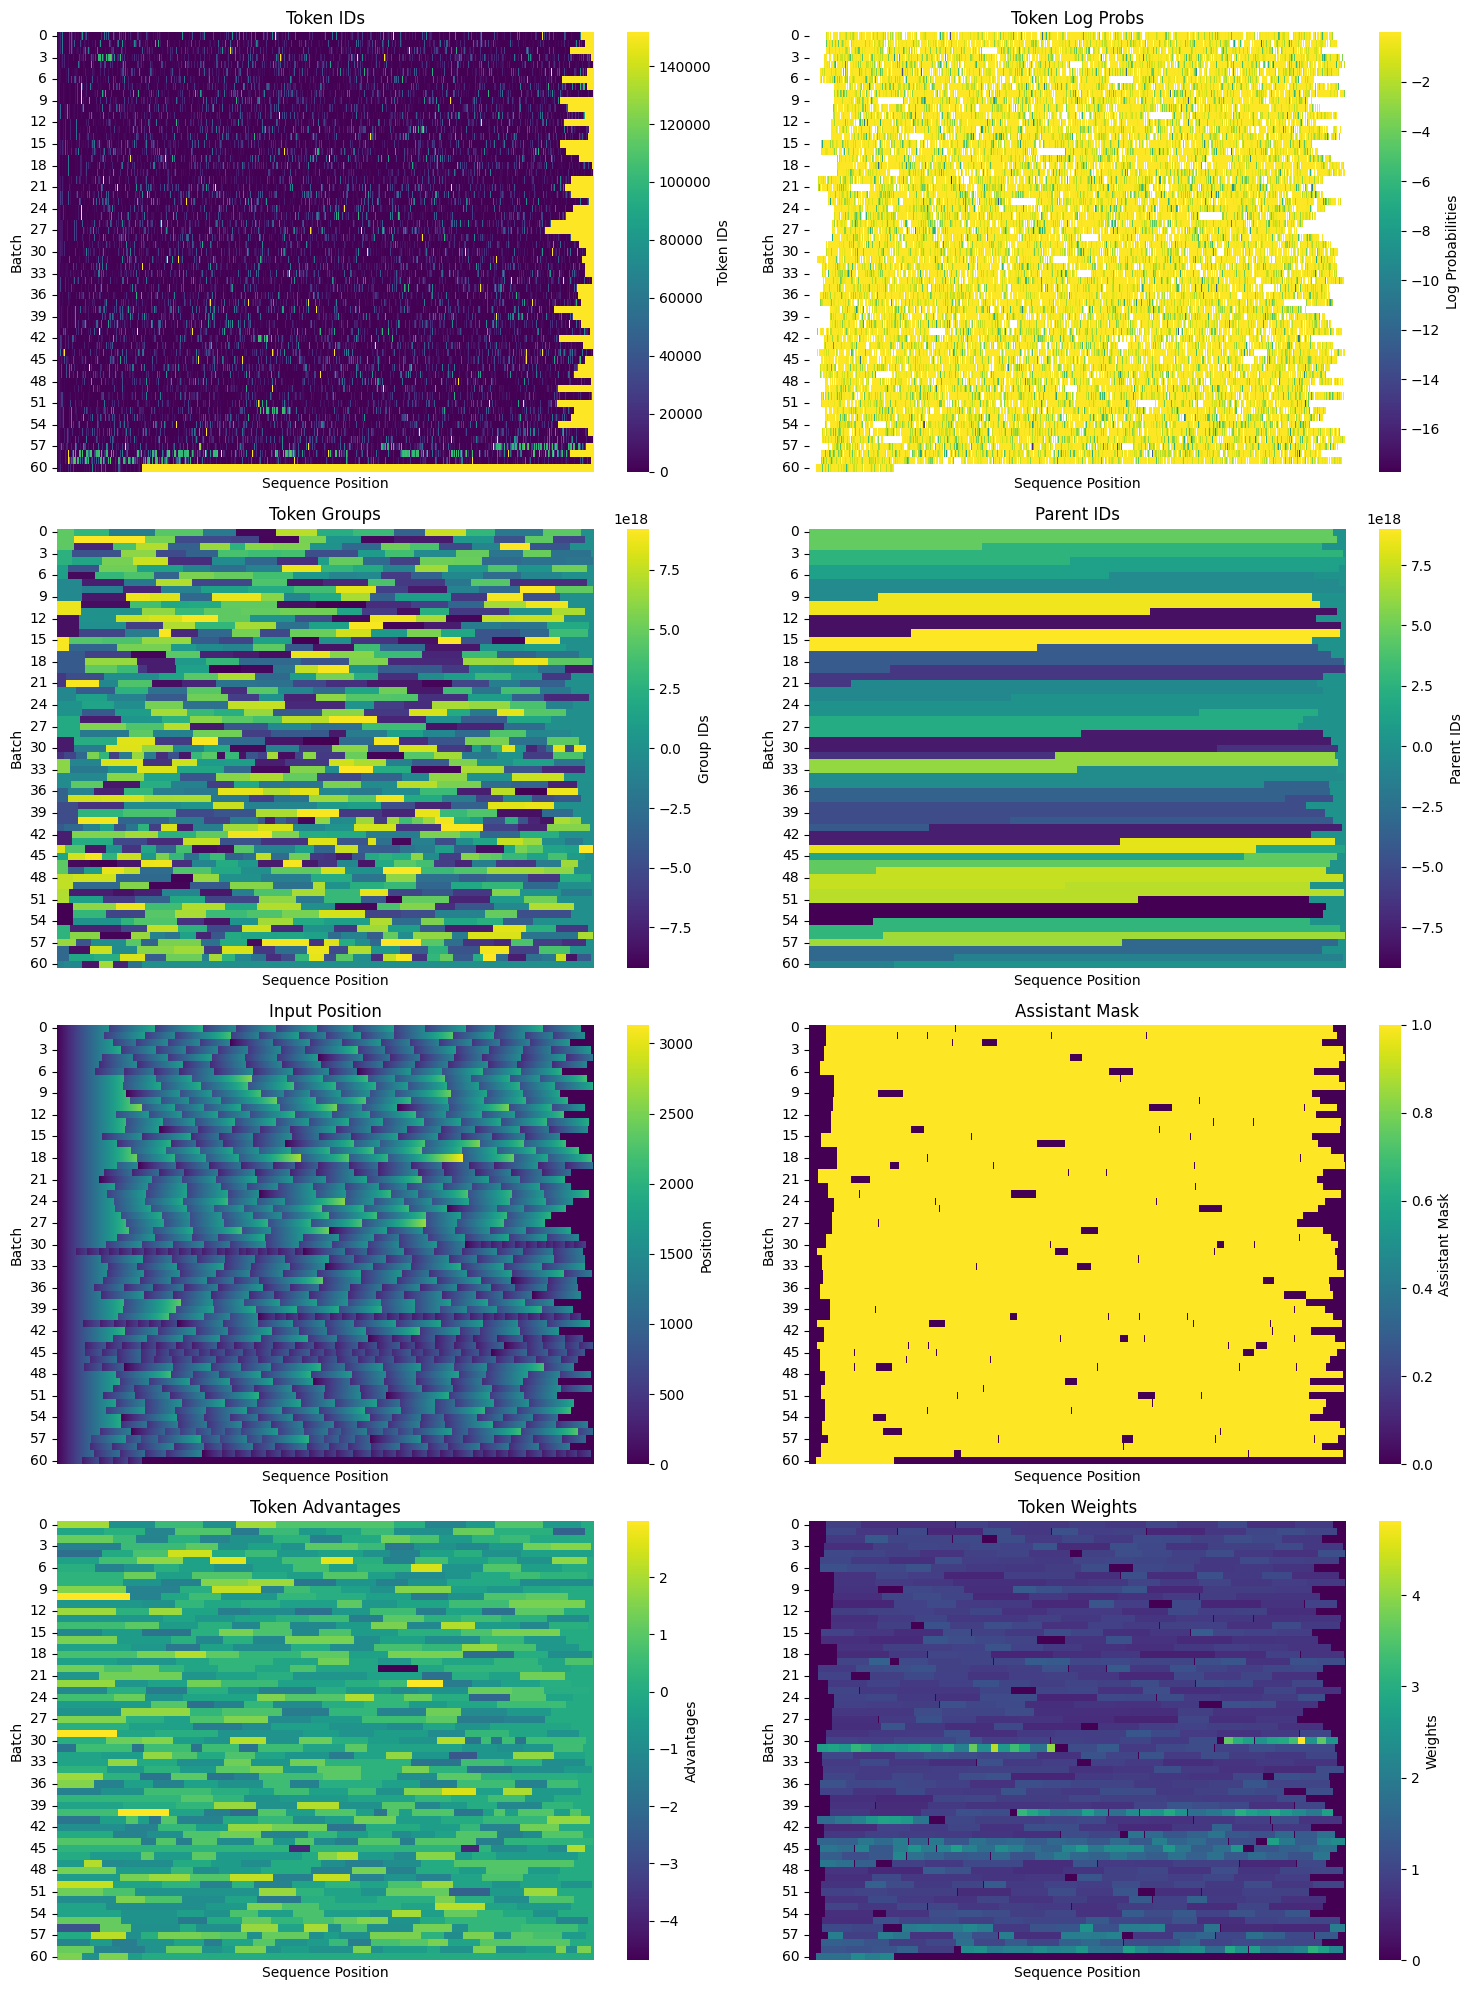

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0222 01:01:33.493000 132355 torch/distributed/run.py:793] 
W0222 01:01:33.493000 132355 torch/distributed/run.py:793] *****************************************
W0222 01:01:33.493000 132355 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0222 01:01:33.493000 132355 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0038
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007

Writing logs to models/031/logs/log_1740186098.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 25.14 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|15|Loss: -0.0000: 100%|██████████| 15/15 [08:29<00:00, 32.52s/it, entropy=0.473, kl_div=nan, loss=-2e-5, policy=-2e-5]        INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

Saved iteration #39 model files to ./models/031/0039
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0039 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0039 --port=8000 --api-key=default
INFO 02-22 01:11:33 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 01:11:34 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 01:11:34 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0039', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.57s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.62s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.65s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.67s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:07,  2.65s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.65s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.66s/it]


(VllmWorkerProcess pid=135230) INFO 02-22 01:12:08 model_runner.py:1115] Loading model weights took 13.9281 GB


Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.14s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.44s/it]



INFO 02-22 01:12:09 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=135230) INFO 02-22 01:12:11 worker.py:267] Memory profiling takes 2.24 seconds
(VllmWorkerProcess pid=135230) INFO 02-22 01:12:11 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=135230) INFO 02-22 01:12:11 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-22 01:12:11 worker.py:267] Memory profiling takes 2.53 seconds
INFO 02-22 01:12:11 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-22 01:12:11 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; PyTorch activation peak memory takes 5.70GiB; the rest of the memory reserved for KV Cache is 53.71GiB.
INFO 

INFO:     Started server process [134945]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 01:12:58 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:59248 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:30<00:00,  1.08s/it, completion_tokens=885, prompt_tokens=382, reward=0.604, token_logprobs=906208]
Deleted iteration directory ./models/031/0038


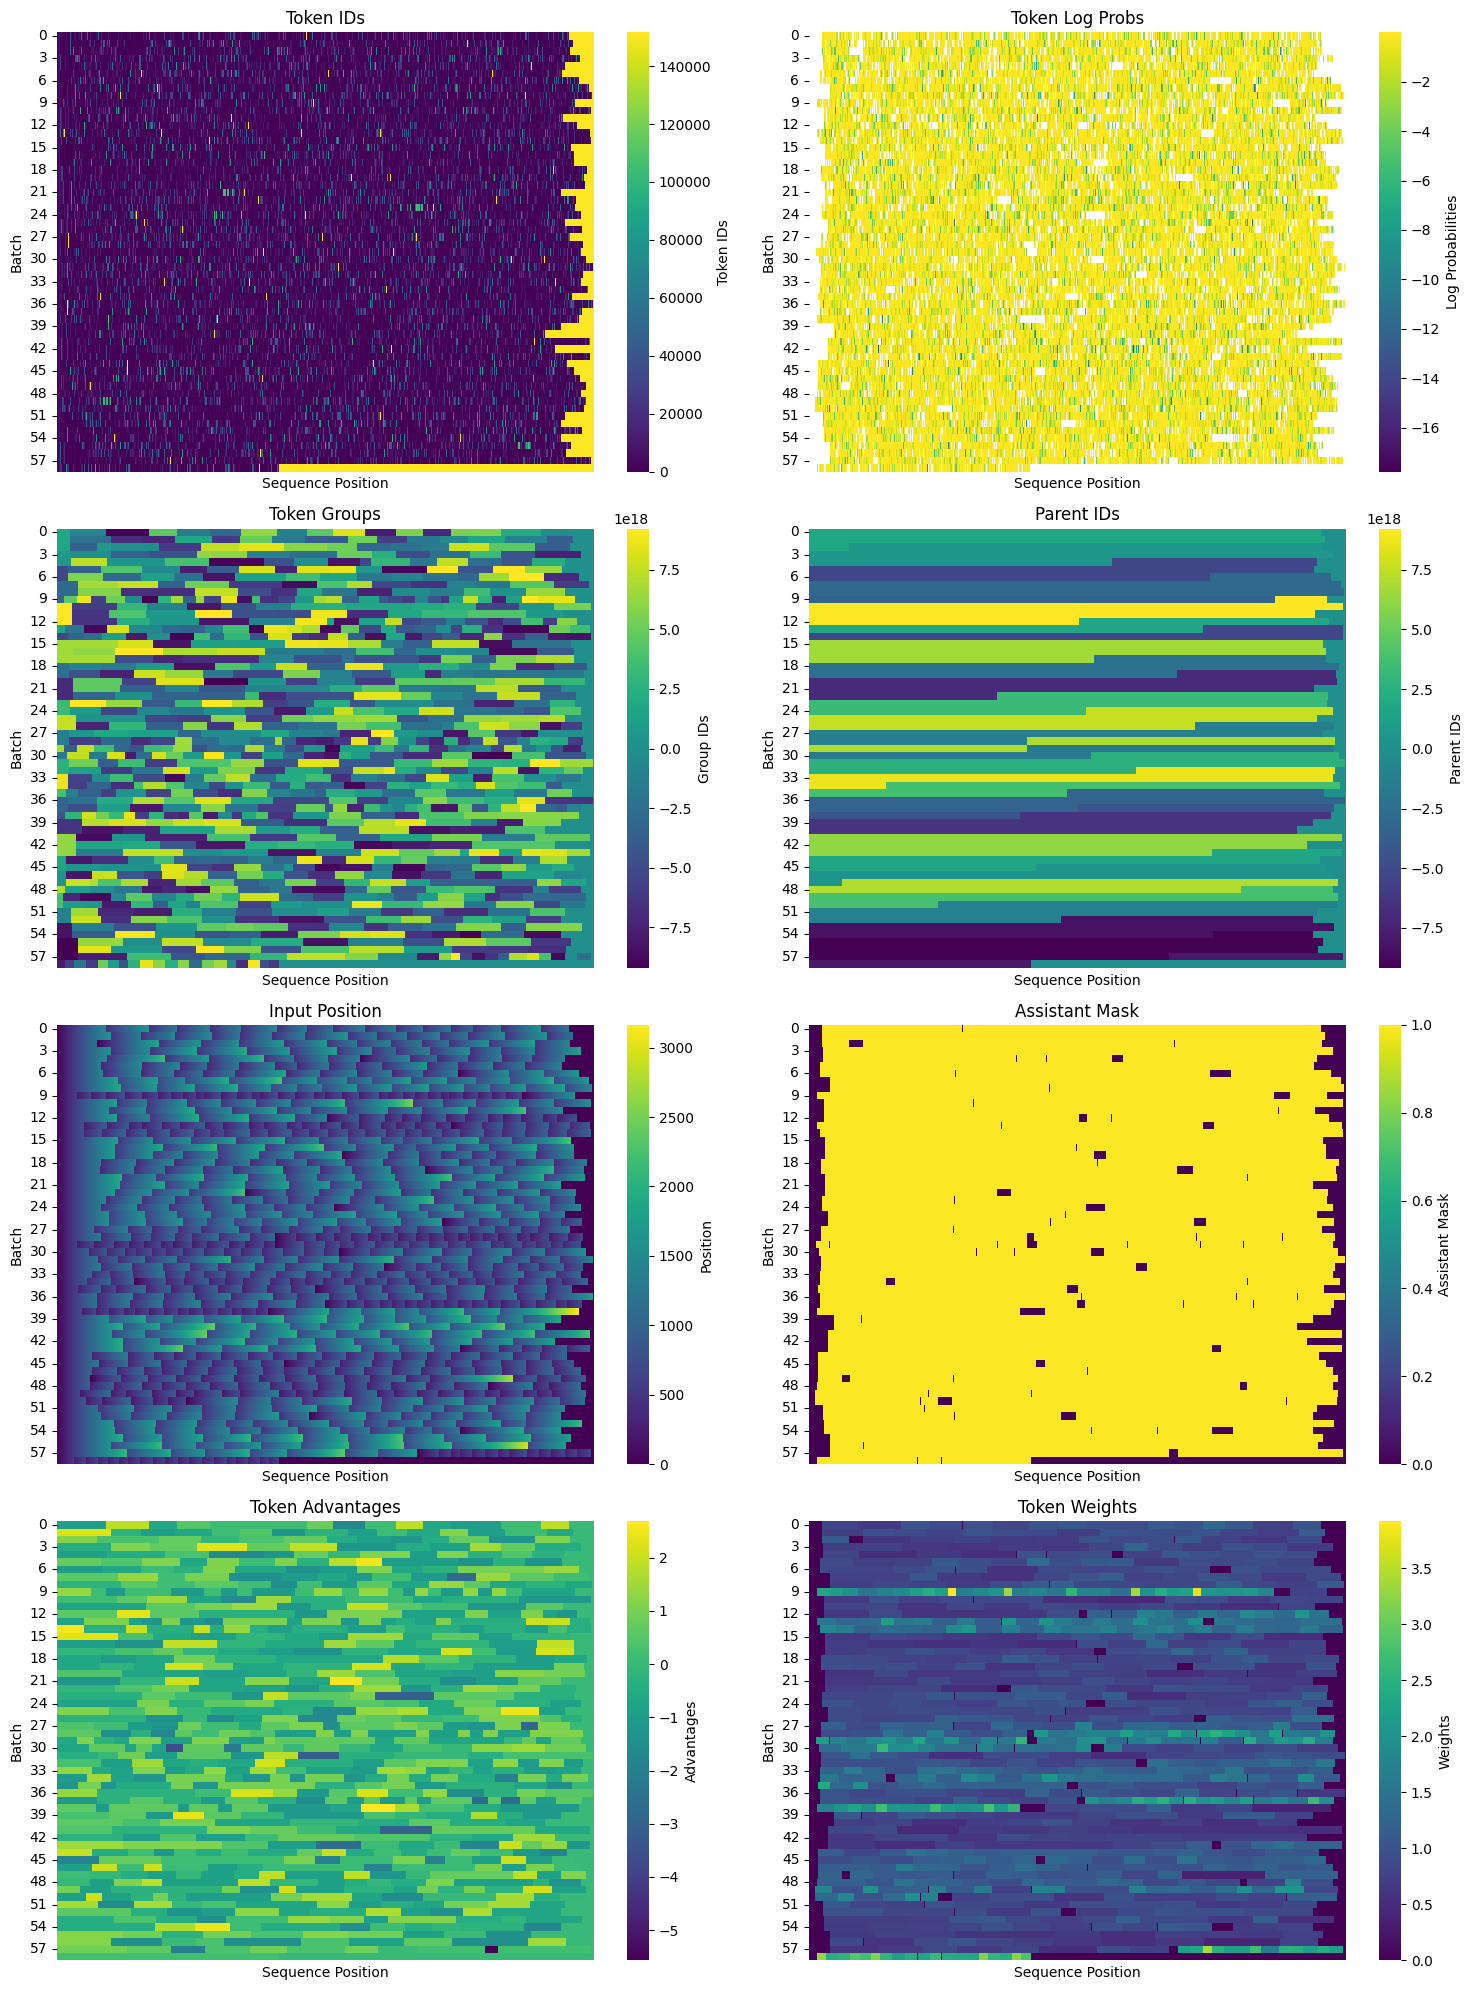

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0222 01:15:53.325000 135519 torch/distributed/run.py:793] 
W0222 01:15:53.325000 135519 torch/distributed/run.py:793] *****************************************
W0222 01:15:53.325000 135519 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0222 01:15:53.325000 135519 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0039
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - hf_model_0004.pt
  - hf_model_0005.pt
  - hf_model_0006.pt
  - hf_model_0007

Writing logs to models/031/logs/log_1740186958.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.90 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|15|Loss: -0.0007: 100%|██████████| 15/15 [08:29<00:00, 32.54s/it, entropy=0.46, kl_div=nan, loss=-0.000708, policy=-0.000708]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict..

Saved iteration #40 model files to ./models/031/0040
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0040 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0040 --port=8000 --api-key=default
INFO 02-22 01:25:53 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 01:25:54 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 01:25:54 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0040', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.50s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.57s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.60s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.62s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:07,  2.62s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.63s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.63s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.11s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.41s/it]



INFO 02-22 01:26:28 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=138265) INFO 02-22 01:26:28 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=138265) INFO 02-22 01:26:31 worker.py:267] Memory profiling takes 2.28 seconds
(VllmWorkerProcess pid=138265) INFO 02-22 01:26:31 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=138265) INFO 02-22 01:26:31 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-22 01:26:31 worker.py:267] Memory profiling takes 2.33 seconds
INFO 02-22 01:26:31 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-22 01:26:31 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB

INFO:     Started server process [137980]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 01:27:18 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:45626 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:56<00:00,  4.79s/it, completion_tokens=965, prompt_tokens=426, reward=0.627, token_logprobs=988515]
Deleted iteration directory ./models/031/0039


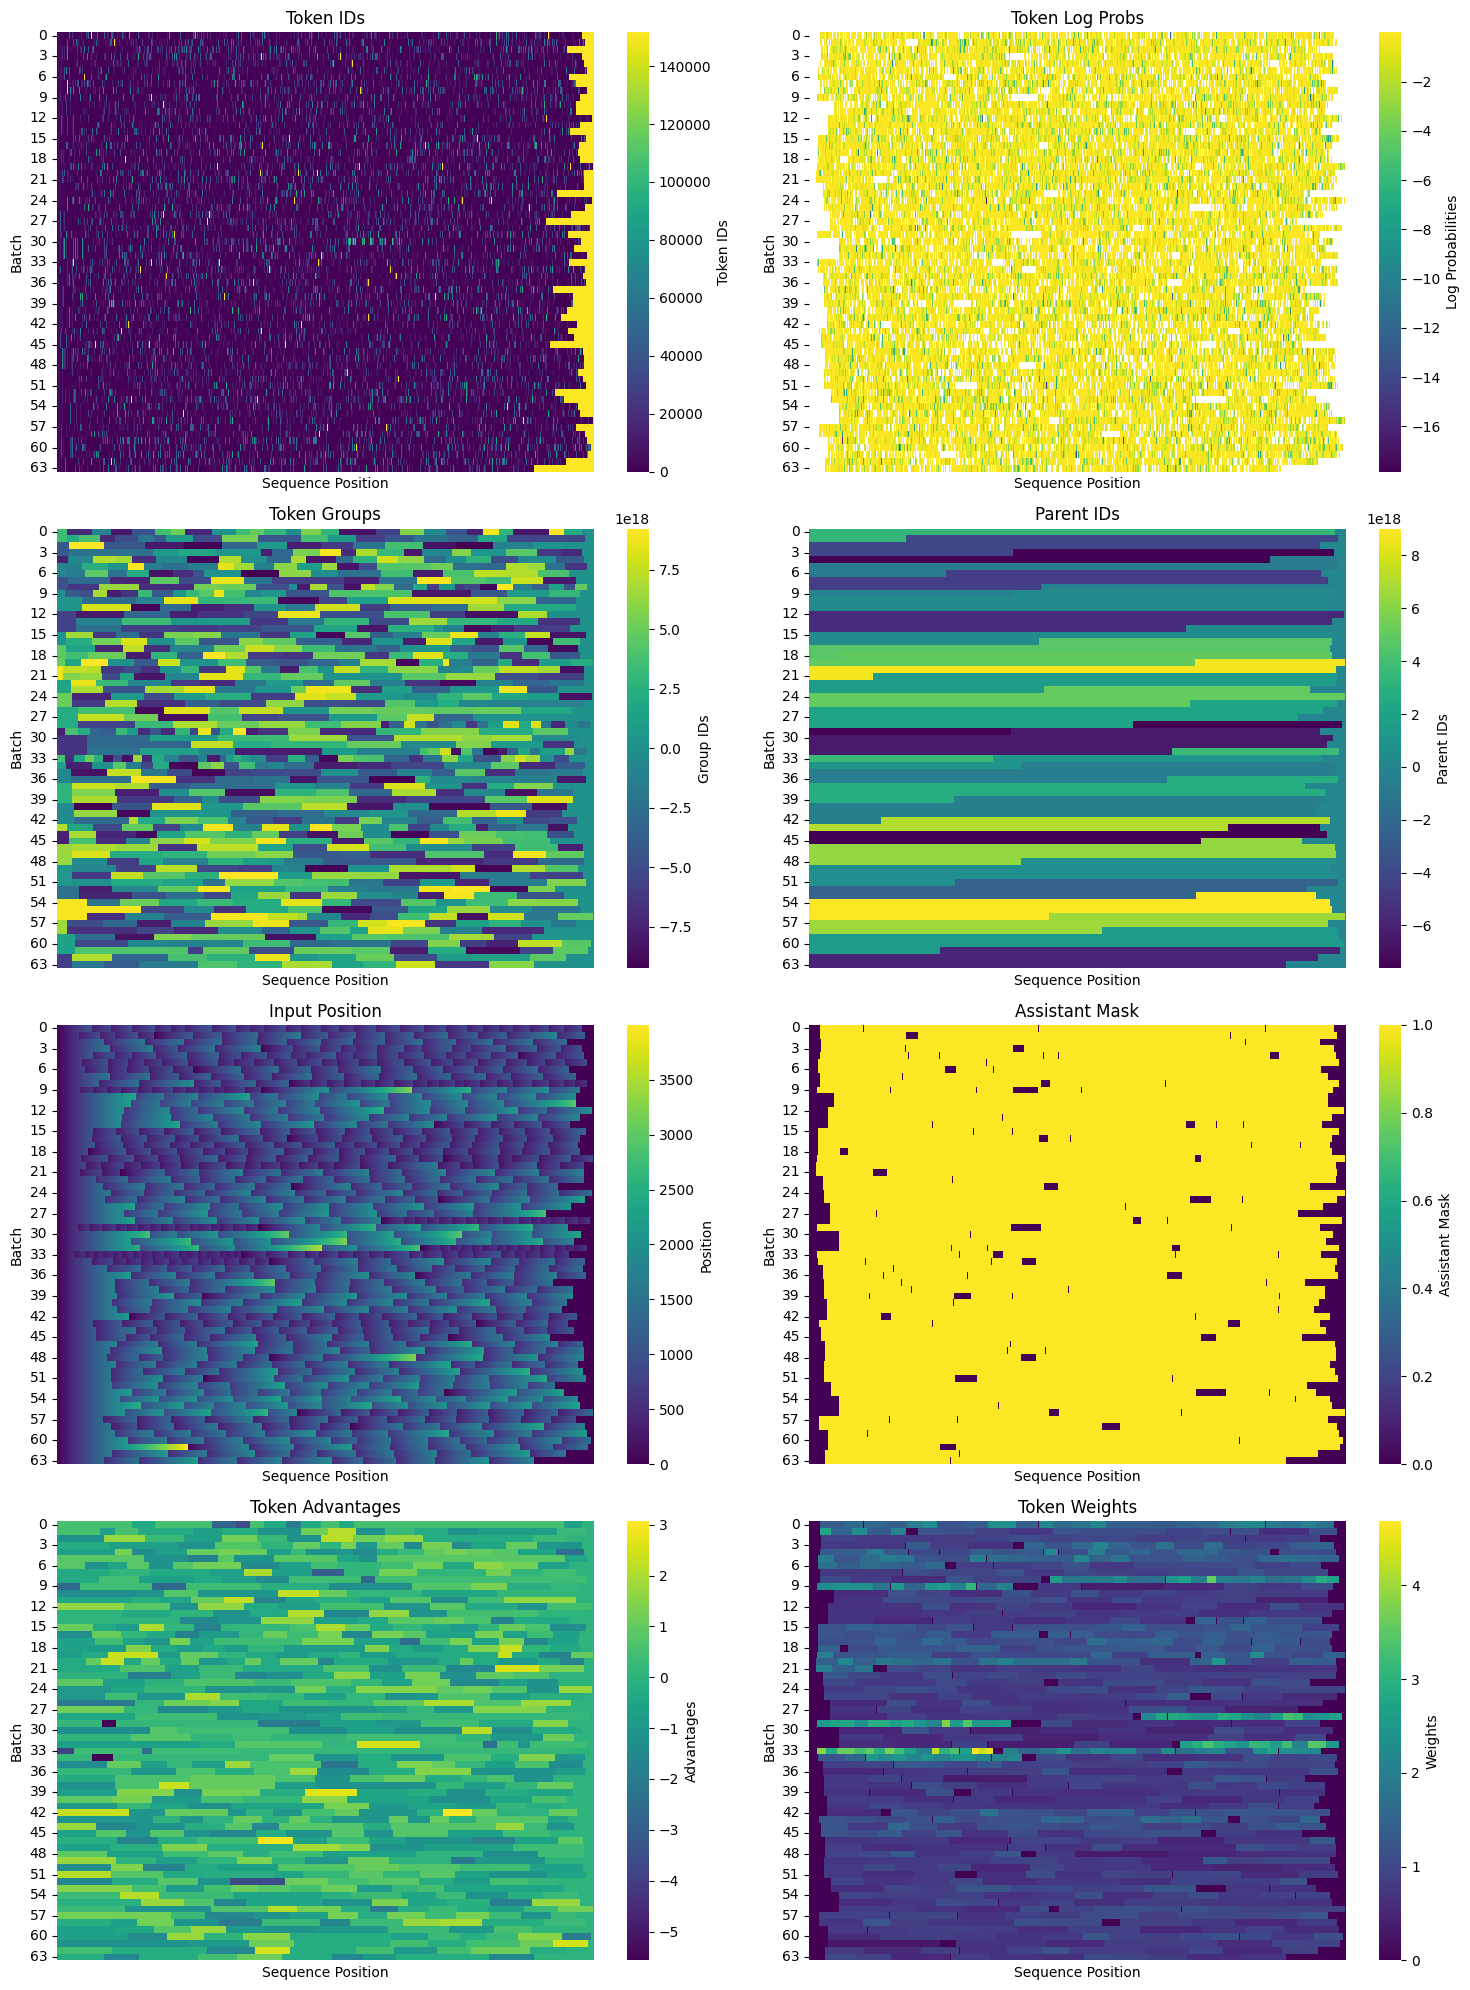

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0222 01:30:39.360000 138530 torch/distributed/run.py:793] 
W0222 01:30:39.360000 138530 torch/distributed/run.py:793] *****************************************
W0222 01:30:39.360000 138530 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0222 01:30:39.360000 138530 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0040
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - 

Writing logs to models/031/logs/log_1740187844.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 25.14 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|16|Loss: 0.0000: 100%|██████████| 16/16 [09:01<00:00, 32.51s/it, entropy=0.559, kl_div=nan, loss=7.58e-6, policy=7.58e-6]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...


Saved iteration #41 model files to ./models/031/0041
$ vllm serve /home/gcpuser/sky_workdir/experiments/models/031/0041 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --served-model-name=./models/031/0041 --port=8000 --api-key=default
INFO 02-22 01:41:11 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 01:41:12 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 01:41:12 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/031/0041', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=N

Loading pt checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading pt checkpoint shards:  12% Completed | 1/8 [00:02<00:17,  2.52s/it]
Loading pt checkpoint shards:  25% Completed | 2/8 [00:05<00:15,  2.60s/it]
Loading pt checkpoint shards:  38% Completed | 3/8 [00:07<00:13,  2.67s/it]
Loading pt checkpoint shards:  50% Completed | 4/8 [00:10<00:10,  2.69s/it]
Loading pt checkpoint shards:  62% Completed | 5/8 [00:13<00:07,  2.66s/it]
Loading pt checkpoint shards:  75% Completed | 6/8 [00:15<00:05,  2.66s/it]
Loading pt checkpoint shards:  88% Completed | 7/8 [00:18<00:02,  2.66s/it]


(VllmWorkerProcess pid=141499) INFO 02-22 01:41:47 model_runner.py:1115] Loading model weights took 13.9281 GB


Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.14s/it]
Loading pt checkpoint shards: 100% Completed | 8/8 [00:19<00:00,  2.45s/it]



INFO 02-22 01:41:47 model_runner.py:1115] Loading model weights took 13.9281 GB
(VllmWorkerProcess pid=141499) INFO 02-22 01:41:50 worker.py:267] Memory profiling takes 2.27 seconds
(VllmWorkerProcess pid=141499) INFO 02-22 01:41:50 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=141499) INFO 02-22 01:41:50 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.21GiB.
INFO 02-22 01:41:50 worker.py:267] Memory profiling takes 2.55 seconds
INFO 02-22 01:41:50 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
INFO 02-22 01:41:50 worker.py:267] model weights take 13.93GiB; non_torch_memory takes 1.82GiB; PyTorch activation peak memory takes 5.70GiB; the rest of the memory reserved for KV Cache is 53.71GiB.
INFO 

INFO:     Started server process [141214]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 01:42:38 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:45110 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1024 [00:00<?, ?it/s]

train: 100%|██████████| 1024/1024 [02:38<00:00,  1.33it/s, completion_tokens=969, prompt_tokens=425, reward=0.617, token_logprobs=992356]
Deleted iteration directory ./models/031/0036


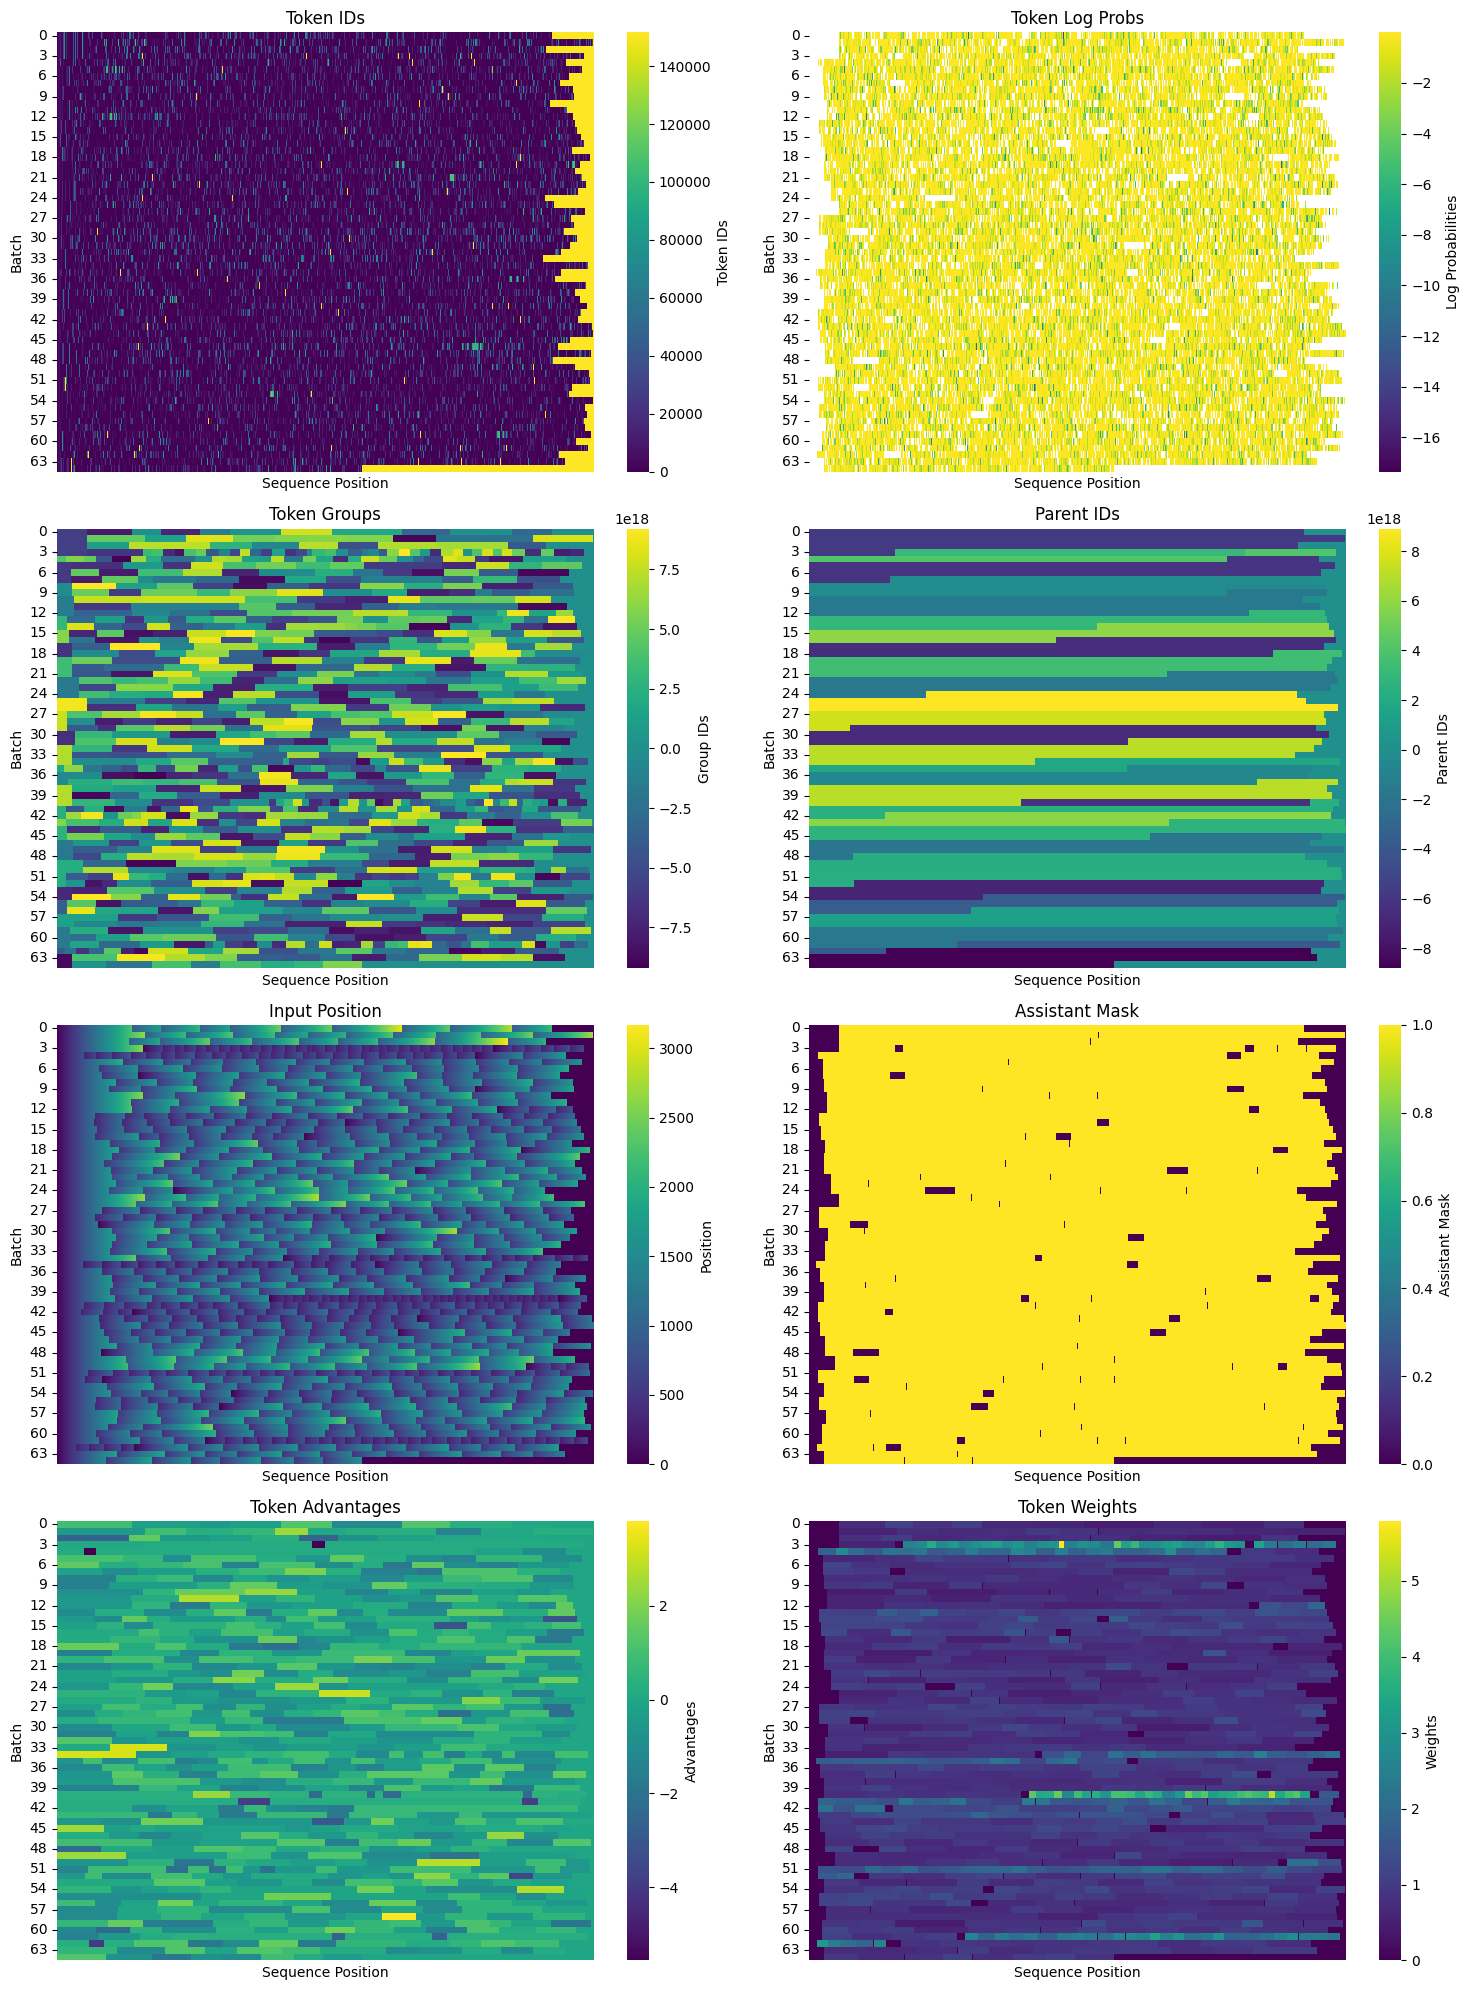

rsyncing /dev/shm/models/031 to /dev/shm/models/031
$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/031/config.yaml
Running with torchrun...


W0222 01:45:47.305000 141768 torch/distributed/run.py:793] 
W0222 01:45:47.305000 141768 torch/distributed/run.py:793] *****************************************
W0222 01:45:47.305000 141768 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0222 01:45:47.305000 141768 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/031/0041
  checkpoint_files:
  - hf_model_0001.pt
  - hf_model_0002.pt
  - hf_model_0003.pt
  - 

Writing logs to models/031/logs/log_1740188752.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.78 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 3.68 GiB
	GPU peak memory reserved: 3.75 GiB
	GPU peak memory active: 3.68 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|8|Loss: -0.0005:  50%|█████     | 8/16 [04:42<04:24, 33.07s/it, entropy=0.468, kl_div=nan, loss=-0.000473, policy=-0.000473]

In [ ]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            n=2,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                }
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                }
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
    except Exception:
        pass
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=2,
            compile=True,
        ),
        verbosity=verbosity,
    )